In [1]:
import numpy as np
import cv2
import scipy.io
import os
from numpy.linalg import norm
from matplotlib import pyplot as plt
from numpy.linalg import det
from numpy.linalg import inv
from scipy.linalg import rq
from numpy.linalg import svd
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import sys
from scipy import ndimage, spatial
from tqdm.notebook import tqdm, trange

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from skimage import io, transform,data
from torchvision import transforms, utils
import numpy as np
import math
import glob
import matplotlib.pyplot as plt
import time
import os
import copy
import sklearn.svm
import cv2
from matplotlib import pyplot as plt
import numpy as np
from os.path import exists
import pandas as pd
import PIL
import random
from google.colab import drive
from sklearn.metrics.cluster import completeness_score
from sklearn.cluster import KMeans
from tqdm import tqdm, tqdm_notebook
from functools import partial
from torchsummary import summary
from torchvision.datasets import ImageFolder
from torch.utils.data.sampler import SubsetRandomSampler
import h5py as h5

#cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
#accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

#print("Accelerator type = ",accelerator)
#print("Pytorch verision: ", torch.__version__)

In [2]:
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#!pip install ipython-autotime

#%load_ext autotime

In [3]:
!pip install opencv-python==3.4.2.17
!pip install opencv-contrib-python==3.4.2.17

In [4]:
class Image:
    def __init__(self, img, position):
        
        self.img = img
        self.position = position

inlier_matchset = []
def features_matching(a,keypointlength,threshold):
  #threshold=0.2
  bestmatch=np.empty((keypointlength),dtype= np.int16)
  img1index=np.empty((keypointlength),dtype=np.int16)
  distance=np.empty((keypointlength))
  index=0
  for j in range(0,keypointlength):
    #For a descriptor fa in Ia, take the two closest descriptors fb1 and fb2 in Ib
    x=a[j]
    listx=x.tolist()
    x.sort()
    minval1=x[0]                                # min 
    minval2=x[1]                                # 2nd min
    itemindex1 = listx.index(minval1)           #index of min val    
    itemindex2 = listx.index(minval2)           #index of second min value 
    ratio=minval1/minval2                       #Ratio Test
    
    if ratio<threshold: 
      #Low distance ratio: fb1 can be a good match
      bestmatch[index]=itemindex1
      distance[index]=minval1
      img1index[index]=j
      index=index+1
  return  [cv2.DMatch(img1index[i],bestmatch[i].astype(int),distance[i]) for i in range(0,index)]
          
   
  
def compute_Homography(im1_pts,im2_pts):
  """
  im1_pts and im2_pts are 2×n matrices with
  4 point correspondences from the two images
  """
  num_matches=len(im1_pts)
  num_rows = 2 * num_matches
  num_cols = 9
  A_matrix_shape = (num_rows,num_cols)
  A = np.zeros(A_matrix_shape)
  a_index = 0
  for i in range(0,num_matches):
    (a_x, a_y) = im1_pts[i]
    (b_x, b_y) = im2_pts[i]
    row1 = [a_x, a_y, 1, 0, 0, 0, -b_x*a_x, -b_x*a_y, -b_x] # First row 
    row2 = [0, 0, 0, a_x, a_y, 1, -b_y*a_x, -b_y*a_y, -b_y] # Second row 

    # place the rows in the matrix
    A[a_index] = row1
    A[a_index+1] = row2

    a_index += 2
    
  U, s, Vt = np.linalg.svd(A)

  #s is a 1-D array of singular values sorted in descending order
  #U, Vt are unitary matrices
  #Rows of Vt are the eigenvectors of A^TA.
  #Columns of U are the eigenvectors of AA^T.
  H = np.eye(3)
  H = Vt[-1].reshape(3,3) # take the last row of the Vt matrix
  return H
  
  
def displayplot(img,title):
  
  plt.figure(figsize=(15,15))
  plt.title(title)
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.show()

In [5]:
def get_inliers(f1, f2, matches, H, RANSACthresh):

  inlier_indices = []
  for i in range(len(matches)):
    queryInd = matches[i].queryIdx
    trainInd = matches[i].trainIdx

    #queryInd = matches[i][0]
    #trainInd = matches[i][1]

    queryPoint = np.array([f1[queryInd].pt[0],  f1[queryInd].pt[1], 1]).T 
    trans_query = H.dot(queryPoint) 

   
    comp1 = [trans_query[0]/trans_query[2], trans_query[1]/trans_query[2]] # normalize with respect to z
    comp2 = np.array(f2[trainInd].pt)[:2]
    

    if(np.linalg.norm(comp1-comp2) <= RANSACthresh): # check against threshold
      inlier_indices.append(i)
  return inlier_indices


def RANSAC_alg(f1, f2, matches, nRANSAC, RANSACthresh):

      
    minMatches = 4
    nBest = 0
    best_inliers = []
    H_estimate = np.eye(3,3)
    global inlier_matchset
    inlier_matchset=[]
    for iteration in range(nRANSAC):
      
        #Choose a minimal set of feature matches.
        matchSample = random.sample(matches, minMatches)
        
        #Estimate the Homography implied by these matches
        im1_pts=np.empty((minMatches,2))
        im2_pts=np.empty((minMatches,2))
        for i in range(0,minMatches):
          m = matchSample[i]
          im1_pts[i] = f1[m.queryIdx].pt
          im2_pts[i] = f2[m.trainIdx].pt
          #im1_pts[i] = f1[m[0]].pt
          #im2_pts[i] = f2[m[1]].pt             
          
        H_estimate=compute_Homography(im1_pts,im2_pts)
        
               
        # Calculate the inliers for the H
        inliers = get_inliers(f1, f2, matches, H_estimate, RANSACthresh)

        # if the number of inliers is higher than previous iterations, update the best estimates
        if len(inliers) > nBest:
            nBest= len(inliers)
            best_inliers = inliers

    print("Number of best inliers",len(best_inliers))
    for i in range(len(best_inliers)):
      inlier_matchset.append(matches[best_inliers[i]])
    
    # compute a homography given this set of matches
    im1_pts=np.empty((len(best_inliers),2))
    im2_pts=np.empty((len(best_inliers),2))
    for i in range(0,len(best_inliers)):
      m = inlier_matchset[i]
      im1_pts[i] = f1[m.queryIdx].pt
      im2_pts[i] = f2[m.trainIdx].pt
      #im1_pts[i] = f1[m[0]].pt
      #im2_pts[i] = f2[m[1]].pt

    M=compute_Homography(im1_pts,im2_pts)
    return M, best_inliers

In [6]:
tqdm = partial(tqdm, position=0, leave=True)

In [7]:
files_all=[]
for file in os.listdir("/content/drive/MyDrive/MAP-20210707T092105Z-001/MAP"):
    if file.endswith(".JPG"):
      files_all.append(file)


files_all.sort()
folder_path = '/content/drive/MyDrive/MAP-20210707T092105Z-001/MAP/'

#centre_file = folder_path + files_all[50]
left_files_path_rev = []
right_files_path = []


#Change this according to your dataset split

for file in files_all[:61]:
  left_files_path_rev.append(folder_path + file)

left_files_path = left_files_path_rev[::-1]

for file in files_all[60:120]:
  right_files_path.append(folder_path + file)

In [8]:
print(len(files_all))

176


In [9]:
from multiprocessing import Pool

In [10]:
import multiprocessing
print(multiprocessing.cpu_count())


2


In [11]:
gridsize = 8
clahe = cv2.createCLAHE(clipLimit=2.0,tileGridSize=(gridsize,gridsize))

images_left_bgr = []
images_right_bgr = []

images_left = []
images_right = []

for file in tqdm(left_files_path):
  left_image_sat= cv2.imread(file)
  lab = cv2.cvtColor(left_image_sat, cv2.COLOR_BGR2LAB)
  lab[...,0] = clahe.apply(lab[...,0])
  left_image_sat = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
  left_img = cv2.resize(left_image_sat,None,fx=0.35, fy=0.35, interpolation = cv2.INTER_CUBIC )
  images_left.append(cv2.cvtColor(left_img, cv2.COLOR_BGR2GRAY).astype('float32')/255.)
  images_left_bgr.append(left_img)


for file in tqdm(right_files_path):
  right_image_sat= cv2.imread(file)
  lab = cv2.cvtColor(right_image_sat, cv2.COLOR_BGR2LAB)
  lab[...,0] = clahe.apply(lab[...,0])
  right_image_sat = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
  right_img = cv2.resize(right_image_sat,None,fx=0.35,fy=0.35, interpolation = cv2.INTER_CUBIC )
  images_right.append(cv2.cvtColor(right_img, cv2.COLOR_BGR2GRAY).astype('float32')/255.)
  images_right_bgr.append(right_img)

100%|██████████| 60/60 [01:54<00:00,  1.91s/it]


In [12]:
Dataset = 'MAP Dataset'

In [13]:
f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','w')
t0=time.time()
f.create_dataset('data',data=images_left_bgr + images_right_bgr)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize(f'drive/MyDrive/all_images_bgr_{Dataset}.h5')/1.e6,'MB')

HDF5  w/o comp.: 3.87860107421875 [s] ... size 887.702213 MB


In [ ]:
'''
f=h5.File(f'drive/MyDrive/all_images_gray_{Dataset}.h5','w')
t0=time.time()
f.create_dataset('data',data=images_left + images_right)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize(f'drive/MyDrive/all_images_gray_{Dataset}.h5')/1.e6,'MB')

In [14]:
del images_left_bgr,images_right_bgr

In [ ]:
#images_left_bgr_no_enhance = []
#images_right_bgr_no_enhance = []

#for file in tqdm(left_files_path):
#  left_image_sat= cv2.imread(file)
#  left_img = cv2.resize(left_image_sat,None,fx=0.35, fy=0.35, interpolation = cv2.INTER_CUBIC)
#  images_left_bgr_no_enhance.append(left_img)

#for file in tqdm(right_files_path):
# right_image_sat= cv2.imread(file)
#  right_img = cv2.resize(right_image_sat,None,fx=0.35,fy=0.35, interpolation = cv2.INTER_CUBIC)
#  images_right_bgr_no_enhance.append(right_img)

In [15]:
from timeit import default_timer as timer

In [16]:
time_all = []

In [17]:
num_kps_sift = []
num_kps_brisk = []
num_kps_agast = []
num_kps_kaze = []
num_kps_akaze = []
num_kps_orb = []
num_kps_mser = []
num_kps_daisy = []
num_kps_surfsift = []
num_kps_fast = []
num_kps_freak = []
num_kps_gftt = []
num_kps_star = []
num_kps_surf = []
num_kps_rootsift = []
num_kps_superpoint = []


In [18]:
images_left_bgr=[]
images_right_bgr=[]

BRISK

In [ ]:
'''Threshl=60;
Octaves=6; 
#PatternScales=1.0f;

start = timer()

brisk = cv2.BRISK_create(Threshl,Octaves)


keypoints_all_left_brisk = []
descriptors_all_left_brisk = []
points_all_left_brisk=[]

keypoints_all_right_brisk = []
descriptors_all_right_brisk = []
points_all_right_brisk=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()  
  kpt = brisk.detect(imgs,None)
  kpt,descrip =  brisk.compute(imgs, kpt)
  keypoints_all_left_brisk.append(kpt)
  descriptors_all_left_brisk.append(descrip)
  #points_all_left_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = brisk.detect(imgs,None)
  kpt,descrip =  brisk.compute(imgs, kpt)
  keypoints_all_right_brisk.append(kpt)
  descriptors_all_right_brisk.append(descrip)
  #points_all_right_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [01:24<00:00,  1.41s/it]


In [ ]:
'''for j in tqdm(keypoints_all_left_brisk + keypoints_all_right_brisk[1:]):
  num_kps_brisk.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 330911.56it/s]


In [ ]:
'''all_feat_brisk_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_brisk):
  all_feat_brisk_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_brisk[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_brisk_left_each.append(temp)
  all_feat_brisk_left.append(all_feat_brisk_left_each)

In [ ]:
'''all_feat_brisk_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_brisk):
  all_feat_brisk_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_brisk[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_brisk_right_each.append(temp)
  all_feat_brisk_right.append(all_feat_brisk_right_each)

In [ ]:
'''del keypoints_all_left_brisk, keypoints_all_right_brisk, descriptors_all_left_brisk, descriptors_all_right_brisk

In [ ]:
'''import pickle
Fdb = open('all_feat_brisk_left.dat', 'wb')
pickle.dump(all_feat_brisk_left,Fdb,-1)
Fdb.close()

In [ ]:
'''import pickle
Fdb = open('all_feat_brisk_right.dat', 'wb')
pickle.dump(all_feat_brisk_right,Fdb,-1)
Fdb.close()

In [ ]:
'''del Fdb, all_feat_brisk_left, all_feat_brisk_right

ORB

In [ ]:
'''orb = cv2.ORB_create(20000)

start = timer()


keypoints_all_left_orb = []
descriptors_all_left_orb = []
points_all_left_orb=[]

keypoints_all_right_orb = []
descriptors_all_right_orb = []
points_all_right_orb=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()    
  kpt = orb.detect(imgs,None)
  kpt,descrip =  orb.compute(imgs, kpt)
  keypoints_all_left_orb.append(kpt)
  descriptors_all_left_orb.append(descrip)
  #points_all_left_orb.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = orb.detect(imgs,None)
  kpt,descrip =  orb.compute(imgs, kpt)
  keypoints_all_right_orb.append(kpt)
  descriptors_all_right_orb.append(descrip)
  #points_all_right_orb.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [00:17<00:00,  3.44it/s]


In [ ]:
'''for j in tqdm(keypoints_all_left_orb + keypoints_all_right_orb[1:]):
  num_kps_orb.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 66779.42it/s]


In [ ]:
'''all_feat_orb_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_orb):
  all_feat_orb_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_orb[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_orb_left_each.append(temp)
  all_feat_orb_left.append(all_feat_orb_left_each)

In [ ]:
'''all_feat_orb_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_orb):
  all_feat_orb_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_orb[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_orb_right_each.append(temp)
  all_feat_orb_right.append(all_feat_orb_right_each)

In [ ]:
'''del keypoints_all_left_orb, keypoints_all_right_orb, descriptors_all_left_orb, descriptors_all_right_orb

In [ ]:
'''import pickle
Fdb = open('all_feat_orb_left.dat', 'wb')
pickle.dump(all_feat_orb_left,Fdb,-1)
Fdb.close()

In [ ]:
'''import pickle
Fdb = open('all_feat_orb_right.dat', 'wb')
pickle.dump(all_feat_orb_right,Fdb,-1)
Fdb.close()

In [ ]:
'''del Fdb, all_feat_orb_left, all_feat_orb_right

KAZE


In [ ]:
'''start = timer()

kaze = cv2.KAZE_create()


keypoints_all_left_kaze = []
descriptors_all_left_kaze = []
points_all_left_kaze=[]

keypoints_all_right_kaze = []
descriptors_all_right_kaze = []
points_all_right_kaze=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = kaze.detect(imgs,None)
  kpt,descrip =  kaze.compute(imgs, kpt)
  keypoints_all_left_kaze.append(kpt)
  descriptors_all_left_kaze.append(descrip)
  #points_all_left_kaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = kaze.detect(imgs,None)
  kpt,descrip =  kaze.compute(imgs, kpt)
  keypoints_all_right_kaze.append(kpt)
  descriptors_all_right_kaze.append(descrip)
  #points_all_right_kaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [07:19<00:00,  7.32s/it]


In [ ]:
'''for j in tqdm(keypoints_all_left_kaze + keypoints_all_right_kaze[1:]):
  num_kps_kaze.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 169924.54it/s]


In [ ]:
'''all_feat_kaze_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_kaze):
  all_feat_kaze_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_kaze[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_kaze_left_each.append(temp)
  all_feat_kaze_left.append(all_feat_kaze_left_each)

In [ ]:
'''all_feat_kaze_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_kaze):
  all_feat_kaze_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_kaze[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_kaze_right_each.append(temp)
  all_feat_kaze_right.append(all_feat_kaze_right_each)

In [ ]:
'''del keypoints_all_left_kaze, keypoints_all_right_kaze, descriptors_all_left_kaze, descriptors_all_right_kaze

In [ ]:
'''import pickle
Fdb = open('all_feat_kaze_left.dat', 'wb')
pickle.dump(all_feat_kaze_left,Fdb,-1)
Fdb.close()

In [ ]:
'''import pickle
Fdb = open('all_feat_kaze_right.dat', 'wb')
pickle.dump(all_feat_kaze_right,Fdb,-1)
Fdb.close()

In [ ]:
'''del Fdb, all_feat_kaze_left, all_feat_kaze_right

AKAZE

In [ ]:
'''from functools import partial
from tqdm import tqdm
tqdm = partial(tqdm, position=0, leave=True)

In [ ]:
'''start = timer()

akaze = cv2.AKAZE_create()


keypoints_all_left_akaze = []
descriptors_all_left_akaze = []
points_all_left_akaze=[]

keypoints_all_right_akaze = []
descriptors_all_right_akaze = []
points_all_right_akaze=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = akaze.detect(imgs,None)
  kpt,descrip =  akaze.compute(imgs, kpt)
  keypoints_all_left_akaze.append(kpt)
  descriptors_all_left_akaze.append(descrip)
  #points_all_left_akaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = akaze.detect(imgs,None)
  kpt,descrip = akaze.compute(imgs, kpt)
  keypoints_all_right_akaze.append(kpt)
  descriptors_all_right_akaze.append(descrip)
  #points_all_right_akaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [01:28<00:00,  1.47s/it]


In [ ]:
'''for j in tqdm(keypoints_all_left_akaze + keypoints_all_right_akaze[1:]):
  num_kps_akaze.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 18709.95it/s]


In [ ]:
'''all_feat_akaze_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_akaze):
  all_feat_akaze_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_akaze[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_akaze_left_each.append(temp)
  all_feat_akaze_left.append(all_feat_akaze_left_each)

In [ ]:
'''all_feat_akaze_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_akaze):
  all_feat_akaze_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_akaze[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_akaze_right_each.append(temp)
  all_feat_akaze_right.append(all_feat_akaze_right_each)

In [ ]:
'''del keypoints_all_left_akaze, keypoints_all_right_akaze, descriptors_all_left_akaze, descriptors_all_right_akaze

In [ ]:
'''import pickle
Fdb = open('all_feat_akaze_left.dat', 'wb')
pickle.dump(all_feat_akaze_left,Fdb,-1)
Fdb.close()

In [ ]:
'''import pickle
Fdb = open('all_feat_akaze_right.dat', 'wb')
pickle.dump(all_feat_akaze_right,Fdb,-1)
Fdb.close()

In [ ]:
'''del Fdb, all_feat_akaze_left, all_feat_akaze_right


STAR + BRIEF

In [ ]:
'''start = timer()

star = cv2.xfeatures2d.StarDetector_create()
brief = cv2.xfeatures2d.BriefDescriptorExtractor_create()

keypoints_all_left_star = []
descriptors_all_left_brief = []
points_all_left_star=[]

keypoints_all_right_star = []
descriptors_all_right_brief = []
points_all_right_star=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = star.detect(imgs,None)
  kpt,descrip =  brief.compute(imgs, kpt)
  keypoints_all_left_star.append(kpt)
  descriptors_all_left_brief.append(descrip)
  #points_all_left_star.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = star.detect(imgs,None)
  kpt,descrip =  brief.compute(imgs, kpt)
  keypoints_all_right_star.append(kpt)
  descriptors_all_right_brief.append(descrip)
  #points_all_right_star.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [00:12<00:00,  5.00it/s]


In [ ]:
'''for j in tqdm(keypoints_all_left_star + keypoints_all_right_star[1:]):
  num_kps_star.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 252795.82it/s]


In [ ]:
'''all_feat_star_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_star):
  all_feat_star_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_brief[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_star_left_each.append(temp)
  all_feat_star_left.append(all_feat_star_left_each)

In [ ]:
'''all_feat_star_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_star):
  all_feat_star_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_brief[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_star_right_each.append(temp)
  all_feat_star_right.append(all_feat_star_right_each)

In [ ]:
'''del keypoints_all_left_star, keypoints_all_right_star, descriptors_all_left_brief, descriptors_all_right_brief

In [ ]:
'''import pickle
Fdb = open('all_feat_star_left.dat', 'wb')
pickle.dump(all_feat_star_left,Fdb,-1)
Fdb.close()

In [ ]:
'''import pickle
Fdb = open('all_feat_star_right.dat', 'wb')
pickle.dump(all_feat_star_right,Fdb,-1)
Fdb.close()

In [ ]:
'''del Fdb, all_feat_star_left, all_feat_star_right


BRISK + FREAK

In [28]:
start = timer()

Threshl=60;
Octaves=6; 
#PatternScales=1.0f;
brisk = cv2.BRISK_create(Threshl,Octaves)

freak = cv2.xfeatures2d.FREAK_create()
keypoints_all_left_freak = []
descriptors_all_left_freak = []
points_all_left_freak=[]

keypoints_all_right_freak = []
descriptors_all_right_freak = []
points_all_right_freak=[]


for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = brisk.detect(imgs)
  kpt,descrip =  freak.compute(imgs, kpt)
  keypoints_all_left_freak.append(kpt)
  descriptors_all_left_freak.append(descrip)
  #points_all_left_freak.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = brisk.detect(imgs,None)
  kpt,descrip =  freak.compute(imgs, kpt)
  keypoints_all_right_freak.append(kpt)
  descriptors_all_right_freak.append(descrip)
  #points_all_right_freak.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [01:21<00:00,  1.36s/it]


In [29]:
for j in tqdm(keypoints_all_left_freak + keypoints_all_right_freak[1:]):
  num_kps_freak.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 190361.75it/s]


In [ ]:
'''
all_feat_freak_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_freak):
  all_feat_freak_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_freak[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_freak_left_each.append(temp)
  all_feat_freak_left.append(all_feat_freak_left_each)

In [ ]:
'''
all_feat_freak_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_freak):
  all_feat_freak_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_freak[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_freak_right_each.append(temp)
  all_feat_freak_right.append(all_feat_freak_right_each)

In [ ]:
'''
del keypoints_all_left_freak, keypoints_all_right_freak, descriptors_all_left_freak, descriptors_all_right_freak

In [ ]:
'''
import pickle
Fdb = open('all_feat_freak_left.dat', 'wb')
pickle.dump(all_feat_freak_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_freak_right.dat', 'wb')
pickle.dump(all_feat_freak_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_freak_left, all_feat_freak_right

MSER + SIFT

In [ ]:
'''
start = timer()

mser = cv2.MSER_create()
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_mser = []
descriptors_all_left_mser = []
points_all_left_mser=[]

keypoints_all_right_mser = []
descriptors_all_right_mser = []
points_all_right_mser=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = mser.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_mser.append(kpt)
  descriptors_all_left_mser.append(descrip)
  #points_all_left_mser.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = mser.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_mser.append(kpt)
  descriptors_all_right_mser.append(descrip)
  #points_all_right_mser.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_mser + keypoints_all_right_mser[1:]):
  num_kps_mser.append(len(j))

In [ ]:
'''
all_feat_mser_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_mser):
  all_feat_mser_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_mser[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_mser_left_each.append(temp)
  all_feat_mser_left.append(all_feat_mser_left_each)

In [ ]:
'''
all_feat_mser_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_mser):
  all_feat_mser_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_mser[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_mser_right_each.append(temp)
  all_feat_mser_right.append(all_feat_mser_right_each)

In [ ]:
'''
del keypoints_all_left_mser, keypoints_all_right_mser, descriptors_all_left_mser, descriptors_all_right_mser

In [ ]:
'''
import pickle
Fdb = open('all_feat_mser_left.dat', 'wb')
pickle.dump(all_feat_mser_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_mser_right.dat', 'wb')
pickle.dump(all_feat_mser_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_mser_left, all_feat_mser_right

AGAST + SIFT

In [30]:

start = timer()

agast = cv2.AgastFeatureDetector_create(threshold = 60)
sift = cv2.xfeatures2d.SIFT_create(nfeatures = 1000, contrastThreshold=0.02, edgeThreshold=4)

keypoints_all_left_agast = []
descriptors_all_left_agast = []
points_all_left_agast=[]

keypoints_all_right_agast = []
descriptors_all_right_agast = []
points_all_right_agast=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = agast.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_agast.append(kpt)
  descriptors_all_left_agast.append(descrip)
  #points_all_left_agast.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = agast.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_agast.append(kpt)
  descriptors_all_right_agast.append(descrip)
  #points_all_right_agast.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [02:54<00:00,  2.91s/it]


In [31]:

for j in tqdm(keypoints_all_left_agast + keypoints_all_right_agast[1:]):
  num_kps_agast.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 68015.74it/s]


In [ ]:
'''
all_feat_agast_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_agast):
  all_feat_agast_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_agast[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_agast_left_each.append(temp)
  all_feat_agast_left.append(all_feat_agast_left_each)

In [ ]:
'''
all_feat_agast_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_agast):
  all_feat_agast_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_agast[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_agast_right_each.append(temp)
  all_feat_agast_right.append(all_feat_agast_right_each)

In [ ]:
'''
del keypoints_all_left_agast, keypoints_all_right_agast, descriptors_all_left_agast, descriptors_all_right_agast

In [ ]:
'''
import pickle
Fdb = open('all_feat_agast_left.dat', 'wb')
pickle.dump(all_feat_agast_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_agast_left

In [ ]:
'''
import pickle
Fdb = open('all_feat_agast_right.dat', 'wb')
pickle.dump(all_feat_agast_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_agast_right

FAST + SIFT

In [32]:

start = timer()


fast = cv2.FastFeatureDetector_create(threshold=60)
sift = cv2.xfeatures2d.SIFT_create(nfeatures = 1000, contrastThreshold=0.02, edgeThreshold=4)

keypoints_all_left_fast = []
descriptors_all_left_fast = []
points_all_left_fast=[]

keypoints_all_right_fast = []
descriptors_all_right_fast = []
points_all_right_fast=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = fast.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_fast.append(kpt)
  descriptors_all_left_fast.append(descrip)
  #points_all_left_fast.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = fast.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_fast.append(kpt)
  descriptors_all_right_fast.append(descrip)
  #points_all_right_fast.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [02:36<00:00,  2.62s/it]


In [33]:

for j in tqdm(keypoints_all_left_fast + keypoints_all_right_fast[1:]):
  num_kps_fast.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 432774.27it/s]


In [ ]:
'''
all_feat_fast_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_fast):
  all_feat_fast_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_fast[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_fast_left_each.append(temp)
  all_feat_fast_left.append(all_feat_fast_left_each)

In [ ]:
'''
all_feat_fast_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_fast):
  all_feat_fast_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_fast[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_fast_right_each.append(temp)
  all_feat_fast_right.append(all_feat_fast_right_each)

In [ ]:
'''
del keypoints_all_left_fast, keypoints_all_right_fast, descriptors_all_left_fast, descriptors_all_right_fast

In [ ]:
'''
import pickle
Fdb = open('all_feat_fast_left.dat', 'wb')
pickle.dump(all_feat_fast_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_fast_right.dat', 'wb')
pickle.dump(all_feat_fast_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_fast_left, all_feat_fast_right

GFTT + SIFT

In [ ]:
'''
start = timer()

gftt = cv2.GFTTDetector_create()
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_gftt = []
descriptors_all_left_gftt = []
points_all_left_gftt=[]

keypoints_all_right_gftt = []
descriptors_all_right_gftt = []
points_all_right_gftt=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = gftt.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_gftt.append(kpt)
  descriptors_all_left_gftt.append(descrip)
  #points_all_left_gftt.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = gftt.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_gftt.append(kpt)
  descriptors_all_right_gftt.append(descrip)
  #points_all_right_gftt.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_gftt + keypoints_all_right_gftt[1:]):
  num_kps_gftt.append(len(j))

In [ ]:
'''
all_feat_gftt_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_gftt):
  all_feat_gftt_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_gftt[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_gftt_left_each.append(temp)
  all_feat_gftt_left.append(all_feat_gftt_left_each)

In [ ]:
'''
all_feat_gftt_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_gftt):
  all_feat_gftt_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_gftt[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_gftt_right_each.append(temp)
  all_feat_gftt_right.append(all_feat_gftt_right_each)

In [ ]:
'''
del keypoints_all_left_gftt, keypoints_all_right_gftt, descriptors_all_left_gftt, descriptors_all_right_gftt

In [ ]:
'''
import pickle
Fdb = open('all_feat_gftt_left.dat', 'wb')
pickle.dump(all_feat_gftt_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_gftt_right.dat', 'wb')
pickle.dump(all_feat_gftt_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_gftt_left, all_feat_gftt_right

DAISY+SIFT

In [ ]:
'''
start = timer()

daisy = cv2.xfeatures2d.DAISY_create()
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_daisy = []
descriptors_all_left_daisy = []
points_all_left_daisy=[]

keypoints_all_right_daisy = []
descriptors_all_right_daisy = []
points_all_right_daisy=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = sift.detect(imgs,None)
  kpt,descrip =  daisy.compute(imgs, kpt)
  keypoints_all_left_daisy.append(kpt)
  descriptors_all_left_daisy.append(descrip)
  #points_all_left_daisy.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = sift.detect(imgs,None)
  kpt,descrip =  daisy.compute(imgs, kpt)
  keypoints_all_right_daisy.append(kpt)
  descriptors_all_right_daisy.append(descrip)
  #points_all_right_daisy.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_daisy + keypoints_all_right_daisy[1:]):
  num_kps_daisy.append(len(j))

In [ ]:
'''
all_feat_daisy_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_daisy):
  all_feat_daisy_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_daisy[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_daisy_left_each.append(temp)
  all_feat_daisy_left.append(all_feat_daisy_left_each)

In [ ]:
'''
all_feat_daisy_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_daisy):
  all_feat_daisy_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_daisy[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_daisy_right_each.append(temp)
  all_feat_daisy_right.append(all_feat_daisy_right_each)

In [ ]:
'''
del keypoints_all_left_daisy, keypoints_all_right_daisy, descriptors_all_left_daisy, descriptors_all_right_daisy

In [ ]:
'''
import pickle
Fdb = open('all_feat_daisy_left.dat', 'wb')
pickle.dump(all_feat_daisy_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_daisy_right.dat', 'wb')
pickle.dump(all_feat_daisy_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_daisy_left, all_feat_daisy_right

SURF + SIFT

In [ ]:
'''
start = timer()

surf = cv2.xfeatures2d.SURF_create(upright=1)
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_surfsift = []
descriptors_all_left_surfsift = []
points_all_left_surfsift=[]

keypoints_all_right_surfsift = []
descriptors_all_right_surfsift = []
points_all_right_surfsift=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File('drive/MyDrive/all_images_bgr_sift_40.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = surf.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_surfsift.append(kpt)
  descriptors_all_left_surfsift.append(descrip)
  #points_all_left_surfsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File('drive/MyDrive/all_images_bgr_sift_40.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = surf.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_surfsift.append(kpt)
  descriptors_all_right_surfsift.append(descrip)
  #points_all_right_surfsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_surfsift + keypoints_all_right_surfsift[1:]):
  num_kps_surfsift.append(len(j))

In [ ]:
'''
all_feat_surfsift_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_surfsift):
  all_feat_surfsift_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_surfsift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_surfsift_left_each.append(temp)
  all_feat_surfsift_left.append(all_feat_surfsift_left_each)

In [ ]:
'''
all_feat_surfsift_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_surfsift):
  all_feat_surfsift_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_surfsift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_surfsift_right_each.append(temp)
  all_feat_surfsift_right.append(all_feat_surfsift_right_each)

In [ ]:
'''
del keypoints_all_left_surfsift, keypoints_all_right_surfsift, descriptors_all_left_surfsift, descriptors_all_right_surfsift

In [ ]:
'''
import pickle
Fdb = open('all_feat_surfsift_left.dat', 'wb')
pickle.dump(all_feat_surfsift_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_surfsift_right.dat', 'wb')
pickle.dump(all_feat_surfsift_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_surfsift_left, all_feat_surfsift_right

SIFT

In [34]:

print(len(left_files_path))

61


In [35]:

print(len(right_files_path))

60


In [ ]:
# H5 file w/o compression
#t0=time.time()
#f=h5.File('drive/MyDrive/all_images_bgr_sift.h5','r')
#print('HDF5  w/o comp.: data shape =',len(f['data'][0]),time.time()-t0,'[s]')
#f.close()

In [ ]:
#del f

In [37]:

start = timer()

sift = cv2.xfeatures2d.SIFT_create(nfeatures = 2000, contrastThreshold=0.02, edgeThreshold=6 )
keypoints_all_left_sift = []
descriptors_all_left_sift = []
points_all_left_sift=[]

keypoints_all_right_sift = []
descriptors_all_right_sift = []
points_all_right_sift=[]


for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()
  kpt = sift.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_sift.append(kpt)
  descriptors_all_left_sift.append(descrip)
  #points_all_left_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()
  kpt = sift.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_sift.append(kpt)
  descriptors_all_right_sift.append(descrip)
  #points_all_right_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [01:20<00:00,  1.34s/it]


In [38]:

for j in tqdm(keypoints_all_left_sift + keypoints_all_right_sift[1:]):
  num_kps_sift.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 339162.05it/s]


In [ ]:
'''
all_feat_sift_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_sift):
  all_feat_sift_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_sift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_sift_left_each.append(temp)
  all_feat_sift_left.append(all_feat_sift_left_each)

In [ ]:
'''
all_feat_sift_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_sift):
  all_feat_sift_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_sift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_sift_right_each.append(temp)
  all_feat_sift_right.append(all_feat_sift_right_each)

In [ ]:
'''
del keypoints_all_left_sift, keypoints_all_right_sift, descriptors_all_left_sift, descriptors_all_right_sift

In [ ]:
'''
import pickle
Fdb = open('all_feat_sift_left.dat', 'wb')
pickle.dump(all_feat_sift_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_sift_right.dat', 'wb')
pickle.dump(all_feat_sift_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_sift_left, all_feat_sift_right

In [ ]:
#del keypoints_all_right_sift, keypoints_all_left_sift, descriptors_all_right_sift, descriptors_all_left_sift, points_all_right_sift, points_all_left_sift

SURF

In [39]:

start = timer()

surf  = cv2.xfeatures2d.SURF_create(nOctaves = 3, hessianThreshold = 60 ,upright=1)
keypoints_all_left_surf = []
descriptors_all_left_surf = []
points_all_left_surf=[]

keypoints_all_right_surf = []
descriptors_all_right_surf = []
points_all_right_surf=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()  
  kpt = surf.detect(imgs,None)
  kpt,descrip =  surf.compute(imgs, kpt)
  keypoints_all_left_surf.append(kpt)
  descriptors_all_left_surf.append(descrip)
  #points_all_left_surf.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = surf.detect(imgs,None)
  kpt,descrip =  surf.compute(imgs, kpt)
  keypoints_all_right_surf.append(kpt)
  descriptors_all_right_surf.append(descrip)
  #points_all_right_surf.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [02:10<00:00,  2.18s/it]


In [40]:

for j in tqdm(keypoints_all_left_surf + keypoints_all_right_surf[1:]):
  num_kps_surf.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 147211.61it/s]


In [ ]:
'''
all_feat_surf_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_surf):
  all_feat_surf_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_surf[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_surf_left_each.append(temp)
  all_feat_surf_left.append(all_feat_surf_left_each)

In [ ]:
'''
all_feat_surf_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_surf):
  all_feat_surf_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_surf[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_surf_right_each.append(temp)
  all_feat_surf_right.append(all_feat_surf_right_each)

In [ ]:
'''
del keypoints_all_left_surf, keypoints_all_right_surf, descriptors_all_left_surf, descriptors_all_right_surf

In [ ]:
'''
import pickle
Fdb = open('all_feat_surf_left.dat', 'wb')
pickle.dump(all_feat_surf_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_surf_right.dat', 'wb')
pickle.dump(all_feat_surf_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_surf_left, all_feat_surf_right

ROOTSIFT

In [ ]:
'''class RootSIFT:
  def __init__(self):
    # initialize the SIFT feature extractor
    #self.extractor = cv2.DescriptorExtractor_create("SIFT")
    self.sift = cv2.xfeatures2d.SIFT_create()

  def compute(self, image, kps, eps=1e-7):
    # compute SIFT descriptors
    (kps, descs) = self.sift.compute(image, kps)

    # if there are no keypoints or descriptors, return an empty tuple
    if len(kps) == 0:
      return ([], None)

    # apply the Hellinger kernel by first L1-normalizing, taking the
    # square-root, and then L2-normalizing
    descs /= (np.linalg.norm(descs, axis=0, ord=2) + eps)
    descs /= (descs.sum(axis=0) + eps)
    descs = np.sqrt(descs)
    #descs /= (np.linalg.norm(descs, axis=0, ord=2) + eps)

    # return a tuple of the keypoints and descriptors
    return (kps, descs)

In [ ]:
'''start = timer()

sift = cv2.xfeatures2d.SIFT_create()
rootsift = RootSIFT()
keypoints_all_left_rootsift = []
descriptors_all_left_rootsift = []
points_all_left_rootsift=[]

keypoints_all_right_rootsift = []
descriptors_all_right_rootsift = []
points_all_right_rootsift=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()  
  kpt = sift.detect(imgs,None)
  kpt,descrip =  rootsift.compute(imgs, kpt)
  keypoints_all_left_rootsift.append(kpt)
  descriptors_all_left_rootsift.append(descrip)
  #points_all_left_rootsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = sift.detect(imgs,None)
  kpt,descrip =  rootsift.compute(imgs, kpt)
  keypoints_all_right_rootsift.append(kpt)
  descriptors_all_right_rootsift.append(descrip)
  #points_all_right_rootsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [02:57<00:00,  2.95s/it]


In [ ]:
'''for j in tqdm(keypoints_all_left_rootsift + keypoints_all_right_rootsift[1:]):
  num_kps_rootsift.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 48989.34it/s]


In [ ]:
'''all_feat_rootsift_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_rootsift):
  all_feat_rootsift_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_rootsift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_rootsift_left_each.append(temp)
  all_feat_rootsift_left.append(all_feat_rootsift_left_each)

In [ ]:
'''all_feat_rootsift_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_rootsift):
  all_feat_rootsift_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_rootsift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_rootsift_right_each.append(temp)
  all_feat_rootsift_right.append(all_feat_rootsift_right_each)

In [ ]:
'''del keypoints_all_left_rootsift, keypoints_all_right_rootsift, descriptors_all_left_rootsift, descriptors_all_right_rootsift

In [ ]:
'''import pickle
Fdb = open('all_feat_rootsift_left.dat', 'wb')
pickle.dump(all_feat_rootsift_left,Fdb,-1)
Fdb.close()

In [ ]:
'''import pickle
Fdb = open('all_feat_rootsift_right.dat', 'wb')
pickle.dump(all_feat_rootsift_right,Fdb,-1)
Fdb.close()

In [ ]:
'''del Fdb, all_feat_rootsift_left, all_feat_rootsift_right

SuperPoint

In [ ]:
'''
!git clone https://github.com/magicleap/SuperPointPretrainedNetwork.git

In [ ]:
'''
weights_path = 'SuperPointPretrainedNetwork/superpoint_v1.pth'

cuda = 'True'

In [ ]:
'''
def to_kpts(pts, size=1):
  return [cv2.KeyPoint(pt[0], pt[1], size) for pt in pts]

In [ ]:
'''
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

torch.cuda.empty_cache()

class SuperPointNet(nn.Module):
    def __init__(self):
        super(SuperPointNet, self).__init__()
        self.relu = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        c1, c2, c3, c4, c5, d1 = 64, 64, 128, 128, 256, 256
        # Shared Encoder.
        self.conv1a = nn.Conv2d(1, c1, kernel_size=3, stride=1, padding=1)
        self.conv1b = nn.Conv2d(c1, c1, kernel_size=3, stride=1, padding=1)
        self.conv2a = nn.Conv2d(c1, c2, kernel_size=3, stride=1, padding=1)
        self.conv2b = nn.Conv2d(c2, c2, kernel_size=3, stride=1, padding=1)
        self.conv3a = nn.Conv2d(c2, c3, kernel_size=3, stride=1, padding=1)
        self.conv3b = nn.Conv2d(c3, c3, kernel_size=3, stride=1, padding=1)
        self.conv4a = nn.Conv2d(c3, c4, kernel_size=3, stride=1, padding=1)
        self.conv4b = nn.Conv2d(c4, c4, kernel_size=3, stride=1, padding=1)
        # Detector Head.
        self.convPa = nn.Conv2d(c4, c5, kernel_size=3, stride=1, padding=1)
        self.convPb = nn.Conv2d(c5, 65, kernel_size=1, stride=1, padding=0)
        # Descriptor Head.
        self.convDa = nn.Conv2d(c4, c5, kernel_size=3, stride=1, padding=1)
        self.convDb = nn.Conv2d(c5, d1, kernel_size=1, stride=1, padding=0)

    def forward(self, x):

        # Shared Encoder.
        x = self.relu(self.conv1a(x))
        x = self.relu(self.conv1b(x))
        x = self.pool(x)
        x = self.relu(self.conv2a(x))
        x = self.relu(self.conv2b(x))
        x = self.pool(x)
        x = self.relu(self.conv3a(x))
        x = self.relu(self.conv3b(x))
        x = self.pool(x)
        x = self.relu(self.conv4a(x))
        x = self.relu(self.conv4b(x))
        # Detector Head.
        cPa = self.relu(self.convPa(x))
        semi = self.convPb(cPa)
        # Descriptor Head.
        cDa = self.relu(self.convDa(x))
        desc = self.convDb(cDa)
        dn = torch.norm(desc, p=2, dim=1) # Compute the norm.
        desc = desc.div(torch.unsqueeze(dn, 1)) # Divide by norm to normalize.
        return semi, desc


class SuperPointFrontend(object):
    def __init__(self, weights_path, nms_dist, conf_thresh, nn_thresh,cuda=True):
        self.name = 'SuperPoint'
        self.cuda = cuda
        self.nms_dist = nms_dist
        self.conf_thresh = conf_thresh
        self.nn_thresh = nn_thresh # L2 descriptor distance for good match.
        self.cell = 8 # Size of each output cell. Keep this fixed.
        self.border_remove = 4 # Remove points this close to the border.

        # Load the network in inference mode.
        self.net = SuperPointNet()
        if cuda:
          # Train on GPU, deploy on GPU.
            self.net.load_state_dict(torch.load(weights_path))
            self.net = self.net.cuda()
        else:
          # Train on GPU, deploy on CPU.
            self.net.load_state_dict(torch.load(weights_path, map_location=lambda storage, loc: storage))
        self.net.eval()

    def nms_fast(self, in_corners, H, W, dist_thresh):

        grid = np.zeros((H, W)).astype(int) # Track NMS data.
        inds = np.zeros((H, W)).astype(int) # Store indices of points.
        # Sort by confidence and round to nearest int.
        inds1 = np.argsort(-in_corners[2,:])
        corners = in_corners[:,inds1]
        rcorners = corners[:2,:].round().astype(int) # Rounded corners.
        # Check for edge case of 0 or 1 corners.
        if rcorners.shape[1] == 0:
            return np.zeros((3,0)).astype(int), np.zeros(0).astype(int)
        if rcorners.shape[1] == 1:
            out = np.vstack((rcorners, in_corners[2])).reshape(3,1)
            return out, np.zeros((1)).astype(int)
        # Initialize the grid.
        for i, rc in enumerate(rcorners.T):
            grid[rcorners[1,i], rcorners[0,i]] = 1
            inds[rcorners[1,i], rcorners[0,i]] = i
        # Pad the border of the grid, so that we can NMS points near the border.
        pad = dist_thresh
        grid = np.pad(grid, ((pad,pad), (pad,pad)), mode='constant')
        # Iterate through points, highest to lowest conf, suppress neighborhood.
        count = 0
        for i, rc in enumerate(rcorners.T):
          # Account for top and left padding.
            pt = (rc[0]+pad, rc[1]+pad)
            if grid[pt[1], pt[0]] == 1: # If not yet suppressed.
                grid[pt[1]-pad:pt[1]+pad+1, pt[0]-pad:pt[0]+pad+1] = 0
                grid[pt[1], pt[0]] = -1
                count += 1
        # Get all surviving -1's and return sorted array of remaining corners.
        keepy, keepx = np.where(grid==-1)
        keepy, keepx = keepy - pad, keepx - pad
        inds_keep = inds[keepy, keepx]
        out = corners[:, inds_keep]
        values = out[-1, :]
        inds2 = np.argsort(-values)
        out = out[:, inds2]
        out_inds = inds1[inds_keep[inds2]]
        return out, out_inds

    def run(self, img):
        assert img.ndim == 2 #Image must be grayscale.
        assert img.dtype == np.float32 #Image must be float32.
        H, W = img.shape[0], img.shape[1]
        inp = img.copy()
        inp = (inp.reshape(1, H, W))
        inp = torch.from_numpy(inp)
        inp = torch.autograd.Variable(inp).view(1, 1, H, W)
        if self.cuda:
            inp = inp.cuda()
        # Forward pass of network.
        outs = self.net.forward(inp)
        semi, coarse_desc = outs[0], outs[1]
        # Convert pytorch -> numpy.
        semi = semi.data.cpu().numpy().squeeze()
        
        # --- Process points.
        dense = np.exp(semi) # Softmax.
        dense = dense / (np.sum(dense, axis=0)+.00001) # Should sum to 1.
        nodust = dense[:-1, :, :]
        # Reshape to get full resolution heatmap.
        Hc = int(H / self.cell)
        Wc = int(W / self.cell)
        nodust = np.transpose(nodust, [1, 2, 0])
        heatmap = np.reshape(nodust, [Hc, Wc, self.cell, self.cell])
        heatmap = np.transpose(heatmap, [0, 2, 1, 3])
        heatmap = np.reshape(heatmap, [Hc*self.cell, Wc*self.cell]) 
        prob_map = heatmap/np.sum(np.sum(heatmap))
        
        return heatmap, coarse_desc


    def key_pt_sampling(self, img, heat_map, coarse_desc, sampled):
        
        H, W = img.shape[0], img.shape[1]

        xs, ys = np.where(heat_map >= self.conf_thresh) # Confidence threshold.
        if len(xs) == 0:
            return np.zeros((3, 0)), None, None
        print("number of pts selected :", len(xs))
        
        
        pts = np.zeros((3, len(xs))) # Populate point data sized 3xN.
        pts[0, :] = ys
        pts[1, :] = xs
        pts[2, :] = heat_map[xs, ys]
        pts, _ = self.nms_fast(pts, H, W, dist_thresh=self.nms_dist) # Apply NMS.
        inds = np.argsort(pts[2,:])
        pts = pts[:,inds[::-1]] # Sort by confidence.
        bord = self.border_remove
        toremoveW = np.logical_or(pts[0, :] < bord, pts[0, :] >= (W-bord))
        toremoveH = np.logical_or(pts[1, :] < bord, pts[1, :] >= (H-bord))
        toremove = np.logical_or(toremoveW, toremoveH)
        pts = pts[:, ~toremove]
        pts = pts[:,0:sampled] #we take 2000 keypoints with highest probability from heatmap for our benchmark
        
        # --- Process descriptor.
        D = coarse_desc.shape[1]
        if pts.shape[1] == 0:
            desc = np.zeros((D, 0))
        else:
          # Interpolate into descriptor map using 2D point locations.
            samp_pts = torch.from_numpy(pts[:2, :].copy())
            samp_pts[0, :] = (samp_pts[0, :] / (float(W)/2.)) - 1.
            samp_pts[1, :] = (samp_pts[1, :] / (float(H)/2.)) - 1.
            samp_pts = samp_pts.transpose(0, 1).contiguous()
            samp_pts = samp_pts.view(1, 1, -1, 2)
            samp_pts = samp_pts.float()
            if self.cuda:
                samp_pts = samp_pts.cuda()            
            desc = nn.functional.grid_sample(coarse_desc, samp_pts)
            desc = desc.data.cpu().numpy().reshape(D, -1)
            desc /= np.linalg.norm(desc, axis=0)[np.newaxis, :]

            
        return pts, desc

In [ ]:
'''
print('Loading pre-trained network.')
# This class runs the SuperPoint network and processes its outputs.
fe = SuperPointFrontend(weights_path=weights_path,nms_dist = 3,conf_thresh = 0.01,nn_thresh=0.5)
print('Successfully loaded pre-trained network.')

In [ ]:
'''
start = timer()

keypoints_all_left_superpoint = []
descriptors_all_left_superpoint = []
points_all_left_superpoint=[]

keypoints_all_right_superpoint = []
descriptors_all_right_superpoint = []
points_all_right_superpoint=[]

tqdm = partial(tqdm, position=0, leave=True)

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_gray_{Dataset}.h5','r')
  lfpth = f['data'][cnt]
  f.close()  
  heatmap1, coarse_desc1 = fe.run(lfpth)
  pts_1, desc_1 = fe.key_pt_sampling(lfpth, heatmap1, coarse_desc1, 80000) #Getting keypoints and descriptors for 1st image

  keypoints_all_left_superpoint.append(to_kpts(pts_1.T))
  descriptors_all_left_superpoint.append(desc_1.T)
  #points_all_left_superpoint.append(pts_1.T)


for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_gray_{Dataset}.h5','r')
  rfpth = f['data'][cnt]
  f.close()  
  heatmap1, coarse_desc1 = fe.run(rfpth)
  pts_1, desc_1 = fe.key_pt_sampling(rfpth, heatmap1, coarse_desc1, 80000) #Getting keypoints and descriptors for 1st image

  keypoints_all_right_superpoint.append(to_kpts(pts_1.T))
  descriptors_all_right_superpoint.append(desc_1.T)
  #points_all_right_superpoint.append(pts_1.T)

end = timer()
time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_superpoint + keypoints_all_right_superpoint[1:]):
  num_kps_superpoint.append(len(j))

In [ ]:
'''
all_feat_superpoint_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_superpoint):
  all_feat_superpoint_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_superpoint[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_superpoint_left_each.append(temp)
  all_feat_superpoint_left.append(all_feat_superpoint_left_each)

In [ ]:
'''
all_feat_superpoint_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_superpoint):
  all_feat_superpoint_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_superpoint[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_superpoint_right_each.append(temp)
  all_feat_superpoint_right.append(all_feat_superpoint_right_each)

In [ ]:
'''
del keypoints_all_left_superpoint, keypoints_all_right_superpoint, descriptors_all_left_superpoint, descriptors_all_right_superpoint

In [ ]:
'''
import pickle
Fdb = open('all_feat_superpoint_left.dat', 'wb')
pickle.dump(all_feat_superpoint_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_superpoint_right.dat', 'wb')
pickle.dump(all_feat_superpoint_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_superpoint_left, all_feat_superpoint_right

Total Matches,Robust Matches and Homography Computation

In [41]:
def compute_homography_fast(matched_pts1, matched_pts2,thresh=4):
    #matched_pts1 = cv2.KeyPoint_convert(matched_kp1)
    #matched_pts2 = cv2.KeyPoint_convert(matched_kp2)

    # Estimate the homography between the matches using RANSAC
    H, inliers = cv2.findHomography(matched_pts1,
                                    matched_pts2,
                                    cv2.RANSAC, ransacReprojThreshold =thresh, maxIters=3000)
    inliers = inliers.flatten()
    return H, inliers

In [42]:
def compute_homography_fast_other(matched_pts1, matched_pts2):
    #matched_pts1 = cv2.KeyPoint_convert(matched_kp1)
    #matched_pts2 = cv2.KeyPoint_convert(matched_kp2)

    # Estimate the homography between the matches using RANSAC
    H, inliers = cv2.findHomography(matched_pts1,
                                    matched_pts2,
                                    0)
    inliers = inliers.flatten()
    return H, inliers

In [43]:
def get_Hmatrix(imgs,keypts,pts,descripts,ratio=0.75,thresh=4,use_lowe=True,disp=False,no_ransac=False,binary=False):
  lff1 = descripts[0]
  lff = descripts[1]

  if use_lowe==False:
    #FLANN_INDEX_KDTREE = 2
    #index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    #search_params = dict(checks=50)
    #flann = cv2.FlannBasedMatcher(index_params, search_params)
    #flann = cv2.BFMatcher()
    if binary==True:
      bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    else:
      bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
      lff1 = np.float32(descripts[0])
      lff = np.float32(descripts[1])


    #matches_lf1_lf = flann.knnMatch(lff1, lff, k=2)
    matches_4 = bf.knnMatch(lff1, lff,k=2)
    matches_lf1_lf = []


    print("\nNumber of matches",len(matches_4))
    '''
    matches_4 = []
    ratio = ratio
    # loop over the raw matches
    for m in matches_lf1_lf:
      # ensure the distance is within a certain ratio of each
      # other (i.e. Lowe’s ratio test)
      #if len(m) == 2 and m[0].distance < m[1].distance * ratio:
          #matches_1.append((m[0].trainIdx, m[0].queryIdx))
      matches_4.append(m[0])
    '''
    print("Number of matches After Lowe's Ratio",len(matches_4))
  else:
    FLANN_INDEX_KDTREE = 2
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    if binary==True:
      bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
      lff1 = np.float32(descripts[0])
      lff = np.float32(descripts[1])
    else:
      bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
      lff1 = np.float32(descripts[0])
      lff = np.float32(descripts[1])


    matches_lf1_lf = flann.knnMatch(lff1, lff, k=2)
    #matches_lf1_lf = bf.knnMatch(lff1, lff,k=2)


    print("\nNumber of matches",len(matches_lf1_lf))
    matches_4 = []
    ratio = ratio
    # loop over the raw matches
    for m in matches_lf1_lf:
      # ensure the distance is within a certain ratio of each
      # other (i.e. Lowe’s ratio test)
      if len(m) == 2 and m[0].distance < m[1].distance * ratio:
          #matches_1.append((m[0].trainIdx, m[0].queryIdx))
        matches_4.append(m[0])
  
    print("Number of matches After Lowe's Ratio",len(matches_4))


  
  matches_idx = np.array([m.queryIdx for m in matches_4])
  imm1_pts = np.array([keypts[0][idx].pt for idx in matches_idx])
  matches_idx = np.array([m.trainIdx for m in matches_4])
  imm2_pts = np.array([keypts[1][idx].pt for idx in matches_idx])
  '''
  # Estimate homography 1
  #Compute H1
  # Estimate homography 1
  #Compute H1
  imm1_pts=np.empty((len(matches_4),2))
  imm2_pts=np.empty((len(matches_4),2))
  for i in range(0,len(matches_4)):
    m = matches_4[i]
    (a_x, a_y) = keypts[0][m.queryIdx].pt
    (b_x, b_y) = keypts[1][m.trainIdx].pt
    imm1_pts[i]=(a_x, a_y)
    imm2_pts[i]=(b_x, b_y)    
  H=compute_Homography(imm1_pts,imm2_pts) 
  #Robustly estimate Homography 1 using RANSAC
  Hn, best_inliers=RANSAC_alg(keypts[0] ,keypts[1], matches_4,  nRANSAC=1000, RANSACthresh=6)
  '''
  
  if no_ransac==True:
    Hn,inliers = compute_homography_fast_other(imm1_pts,imm2_pts)
  else:
    Hn,inliers = compute_homography_fast(imm1_pts,imm2_pts,thresh)  

  inlier_matchset = np.array(matches_4)[inliers.astype(bool)].tolist()
  print("Number of Robust matches",len(inlier_matchset))
  print("\n")
  
  if len(inlier_matchset)<25:
    matches_4 = []
    ratio = 0.85
    # loop over the raw matches
    for m in matches_lf1_lf:
      # ensure the distance is within a certain ratio of each
      # other (i.e. Lowe’s ratio test)
      if len(m) == 2 and m[0].distance < m[1].distance * ratio:
          #matches_1.append((m[0].trainIdx, m[0].queryIdx))
          matches_4.append(m[0])
    print("Number of matches After Lowe's Ratio New",len(matches_4))
  
    matches_idx = np.array([m.queryIdx for m in matches_4])
    imm1_pts = np.array([keypts[0][idx].pt for idx in matches_idx])
    matches_idx = np.array([m.trainIdx for m in matches_4])
    imm2_pts = np.array([keypts[1][idx].pt for idx in matches_idx])
    Hn,inliers = compute_homography_fast(imm1_pts,imm2_pts)  
    inlier_matchset = np.array(matches_4)[inliers.astype(bool)].tolist()
    print("Number of Robust matches New",len(inlier_matchset))
    print("\n")    
  
  #H=compute_Homography(imm1_pts,imm2_pts) 
  #Robustly estimate Homography 1 using RANSAC
  #Hn=RANSAC_alg(keypts[0] ,keypts[1], matches_4,  nRANSAC=1500, RANSACthresh=6)

  #global inlier_matchset   
  
  if disp==True:
    dispimg1=cv2.drawMatches(imgs[0], keypts[0], imgs[1], keypts[1], inlier_matchset, None,flags=2)
    displayplot(dispimg1,'Robust Matching between Reference Image and Right Image ')
  
  
  return Hn/Hn[2,2], len(matches_lf1_lf), len(inlier_matchset)

In [44]:
def get_Hmatrix_rfnet(imgs,pts,descripts,disp=True):

  des1 = descripts[0]
  des2 = descripts[1]

  kp1 = pts[0]
  kp2 = pts[1]


  predict_label, nn_kp2 = nearest_neighbor_distance_ratio_match(des1, des2, kp2, 0.7)
  idx = predict_label.nonzero().view(-1)
  mkp1 = kp1.index_select(dim=0, index=idx.long())  # predict match keypoints in I1
  mkp2 = nn_kp2.index_select(dim=0, index=idx.long())  # predict match keypoints in I2

  #img1, img2 = reverse_img(img1), reverse_img(img2)
  keypoints1 = list(map(to_cv2_kp, mkp1))
  keypoints2 = list(map(to_cv2_kp, mkp2))
  DMatch = list(map(to_cv2_dmatch, np.arange(0, len(keypoints1))))

  imm1_pts=np.empty((len(DMatch),2))
  imm2_pts=np.empty((len(DMatch),2))
  for i in range(0,len(DMatch)):
    m = DMatch[i]
    (a_x, a_y) = keypoints1[m.queryIdx].pt
    (b_x, b_y) = keypoints2[m.trainIdx].pt
    imm1_pts[i]=(a_x, a_y)
    imm2_pts[i]=(b_x, b_y)    
  H=compute_Homography_fast(imm1_pts,imm2_pts) 


  if disp==True:
    dispimg1 = cv2.drawMatches(imgs[0], keypoints1, imgs[1], keypoints2, DMatch, None)
    displayplot(dispimg1,'Robust Matching between Reference Image and Right Image ')


  return H/H[2,2]

In [ ]:
'''
import pickle
Fdb = open('all_feat_brisk_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_brisk = []
descriptors_all_left_brisk = []
points_all_left_brisk = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_brisk.append(keypoints_each)
  descriptors_all_left_brisk.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_brisk_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_brisk = []
descriptors_all_right_brisk = []
points_all_right_brisk = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_brisk.append(keypoints_each)
  descriptors_all_right_brisk.append(descrip_each)

In [ ]:
'''
H_left_brisk = []
H_right_brisk = []

num_matches_brisk = []
num_good_matches_brisk = []

images_left_bgr = []
images_right_bgr = []
for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_brisk[j:j+2][::-1],points_all_left_brisk[j:j+2][::-1],descriptors_all_left_brisk[j:j+2][::-1],0.7,3,use_lowe=True,binary=True)
  H_left_brisk.append(H_a)
  num_matches_brisk.append(matches)
  num_good_matches_brisk.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_brisk[j:j+2][::-1],points_all_right_brisk[j:j+2][::-1],descriptors_all_right_brisk[j:j+2][::-1],0.7,3,use_lowe=True,binary=True)
  H_right_brisk.append(H_a)
  num_matches_brisk.append(matches)
  num_good_matches_brisk.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_brisk_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_brisk)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_brisk_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.020707368850708008 [s] ... size 0.006368 MB


In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_brisk_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_brisk)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_brisk_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.00494694709777832 [s] ... size 0.006296 MB


In [ ]:
'''
del H_left_brisk, H_right_brisk,keypoints_all_left_brisk, keypoints_all_right_brisk, descriptors_all_left_brisk, descriptors_all_right_brisk, points_all_left_brisk, points_all_right_brisk

In [ ]:
'''
import pickle
Fdb = open('all_feat_sift_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_sift = []
descriptors_all_left_sift = []



for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_sift.append(keypoints_each)
  descriptors_all_left_sift.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_sift_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_sift = []
descriptors_all_right_sift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_sift.append(keypoints_each)
  descriptors_all_right_sift.append(descrip_each)

In [45]:

H_left_sift = []
H_right_sift = []

num_matches_sift = []
num_good_matches_sift = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_sift[j:j+2][::-1],points_all_left_sift[j:j+2][::-1],descriptors_all_left_sift[j:j+2][::-1],0.75)
  H_left_sift.append(H_a)
  num_matches_sift.append(matches)
  num_good_matches_sift.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_sift[j:j+2][::-1],points_all_right_sift[j:j+2][::-1],descriptors_all_right_sift[j:j+2][::-1],0.75)
  H_right_sift.append(H_a)
  num_matches_sift.append(matches)
  num_good_matches_sift.append(gd_matches)

  2%|▏         | 1/61 [00:00<00:36,  1.66it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 235
Number of Robust matches 179




  3%|▎         | 2/61 [00:00<00:29,  2.01it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 199
Number of Robust matches 158




  5%|▍         | 3/61 [00:01<00:24,  2.37it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 197
Number of Robust matches 123




  7%|▋         | 4/61 [00:01<00:21,  2.65it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 158
Number of Robust matches 75




  8%|▊         | 5/61 [00:01<00:20,  2.77it/s]


Number of matches 2001
Number of matches After Lowe's Ratio 12
Number of Robust matches 10


Number of matches After Lowe's Ratio New 73
Number of Robust matches New 12




 10%|▉         | 6/61 [00:01<00:17,  3.06it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 424
Number of Robust matches 321




 11%|█▏        | 7/61 [00:02<00:16,  3.32it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 274
Number of Robust matches 242




 13%|█▎        | 8/61 [00:02<00:15,  3.47it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 376
Number of Robust matches 342




 15%|█▍        | 9/61 [00:02<00:14,  3.59it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 442
Number of Robust matches 388




 16%|█▋        | 10/61 [00:02<00:13,  3.74it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 433
Number of Robust matches 421




 18%|█▊        | 11/61 [00:03<00:13,  3.71it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 463
Number of Robust matches 456




 20%|█▉        | 12/61 [00:03<00:12,  3.77it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 496
Number of Robust matches 460




 21%|██▏       | 13/61 [00:03<00:12,  3.77it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 492
Number of Robust matches 420




 23%|██▎       | 14/61 [00:03<00:12,  3.86it/s]


Number of matches 2001
Number of matches After Lowe's Ratio 458
Number of Robust matches 450




 25%|██▍       | 15/61 [00:04<00:11,  3.86it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 460
Number of Robust matches 442




 26%|██▌       | 16/61 [00:04<00:11,  3.84it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 439
Number of Robust matches 422




 28%|██▊       | 17/61 [00:04<00:11,  3.85it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 362
Number of Robust matches 330




 30%|██▉       | 18/61 [00:05<00:11,  3.86it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 370
Number of Robust matches 364




 31%|███       | 19/61 [00:05<00:10,  3.90it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 434
Number of Robust matches 374




 33%|███▎      | 20/61 [00:05<00:10,  3.88it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 481
Number of Robust matches 472




 34%|███▍      | 21/61 [00:05<00:10,  3.85it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 481
Number of Robust matches 457




 36%|███▌      | 22/61 [00:06<00:10,  3.87it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 456
Number of Robust matches 433




 38%|███▊      | 23/61 [00:06<00:09,  3.93it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 374
Number of Robust matches 349




 39%|███▉      | 24/61 [00:06<00:09,  4.06it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 387
Number of Robust matches 365




 41%|████      | 25/61 [00:06<00:09,  3.92it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 24
Number of Robust matches 22


Number of matches After Lowe's Ratio New 85
Number of Robust matches New 30




 43%|████▎     | 26/61 [00:07<00:08,  3.98it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 737
Number of Robust matches 731




 44%|████▍     | 27/61 [00:07<00:08,  3.95it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 447
Number of Robust matches 422




 46%|████▌     | 28/61 [00:07<00:08,  3.94it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 498
Number of Robust matches 478




 48%|████▊     | 29/61 [00:07<00:08,  3.85it/s]


Number of matches 2002
Number of matches After Lowe's Ratio 481
Number of Robust matches 474




 49%|████▉     | 30/61 [00:08<00:08,  3.86it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 478
Number of Robust matches 452




 51%|█████     | 31/61 [00:08<00:07,  3.83it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 481
Number of Robust matches 473




 52%|█████▏    | 32/61 [00:08<00:07,  3.79it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 425
Number of Robust matches 421




 54%|█████▍    | 33/61 [00:08<00:07,  3.85it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 473
Number of Robust matches 451




 56%|█████▌    | 34/61 [00:09<00:06,  3.88it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 495
Number of Robust matches 480




 57%|█████▋    | 35/61 [00:09<00:06,  3.84it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 567
Number of Robust matches 475




 59%|█████▉    | 36/61 [00:09<00:06,  3.77it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 577
Number of Robust matches 536




 61%|██████    | 37/61 [00:09<00:06,  3.77it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 639
Number of Robust matches 601




 62%|██████▏   | 38/61 [00:10<00:06,  3.82it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 611
Number of Robust matches 607




 64%|██████▍   | 39/61 [00:10<00:05,  3.93it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 548
Number of Robust matches 539




 66%|██████▌   | 40/61 [00:10<00:05,  3.87it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 555
Number of Robust matches 542




 67%|██████▋   | 41/61 [00:10<00:05,  3.84it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 26
Number of Robust matches 21


Number of matches After Lowe's Ratio New 90
Number of Robust matches New 36




 69%|██████▉   | 42/61 [00:11<00:05,  3.78it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 748
Number of Robust matches 746




 70%|███████   | 43/61 [00:11<00:04,  3.77it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 536
Number of Robust matches 534




 72%|███████▏  | 44/61 [00:11<00:04,  3.74it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 481
Number of Robust matches 479




 74%|███████▍  | 45/61 [00:12<00:04,  3.81it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 465
Number of Robust matches 433




 75%|███████▌  | 46/61 [00:12<00:03,  3.85it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 396
Number of Robust matches 389




 77%|███████▋  | 47/61 [00:12<00:03,  3.89it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 419
Number of Robust matches 411




 79%|███████▊  | 48/61 [00:12<00:03,  3.86it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 427
Number of Robust matches 425




 80%|████████  | 49/61 [00:13<00:03,  3.94it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 345
Number of Robust matches 342




 82%|████████▏ | 50/61 [00:13<00:02,  3.90it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 371
Number of Robust matches 335




 84%|████████▎ | 51/61 [00:13<00:02,  3.89it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 351
Number of Robust matches 341




 85%|████████▌ | 52/61 [00:13<00:02,  3.88it/s]


Number of matches 2001
Number of matches After Lowe's Ratio 61
Number of Robust matches 47




 87%|████████▋ | 53/61 [00:14<00:02,  3.88it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 685
Number of Robust matches 679




 89%|████████▊ | 54/61 [00:14<00:01,  3.89it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 396
Number of Robust matches 368




 90%|█████████ | 55/61 [00:14<00:01,  3.81it/s]


Number of matches 2001
Number of matches After Lowe's Ratio 446
Number of Robust matches 436




 92%|█████████▏| 56/61 [00:14<00:01,  3.79it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 452
Number of Robust matches 448




 93%|█████████▎| 57/61 [00:15<00:01,  3.82it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 515
Number of Robust matches 507




 95%|█████████▌| 58/61 [00:15<00:00,  3.83it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 504
Number of Robust matches 496




 97%|█████████▋| 59/61 [00:15<00:00,  3.86it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 112
Number of Robust matches 102




  0%|          | 0/60 [00:00<?, ?it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 633
Number of Robust matches 615




  2%|▏         | 1/60 [00:00<00:15,  3.85it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 284
Number of Robust matches 231




  3%|▎         | 2/60 [00:00<00:15,  3.80it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 311
Number of Robust matches 284




  5%|▌         | 3/60 [00:00<00:15,  3.78it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 311
Number of Robust matches 271




  7%|▋         | 4/60 [00:01<00:14,  3.82it/s]


Number of matches 2001
Number of matches After Lowe's Ratio 375
Number of Robust matches 352




  8%|▊         | 5/60 [00:01<00:14,  3.82it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 402
Number of Robust matches 364




 10%|█         | 6/60 [00:01<00:14,  3.76it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 385
Number of Robust matches 371




 12%|█▏        | 7/60 [00:01<00:13,  3.79it/s]


Number of matches 2001
Number of matches After Lowe's Ratio 388
Number of Robust matches 385




 13%|█▎        | 8/60 [00:02<00:13,  3.82it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 356
Number of Robust matches 326




 15%|█▌        | 9/60 [00:02<00:13,  3.78it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 341
Number of Robust matches 309




 17%|█▋        | 10/60 [00:02<00:13,  3.74it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 365
Number of Robust matches 355




 18%|█▊        | 11/60 [00:02<00:13,  3.73it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 417
Number of Robust matches 405




 20%|██        | 12/60 [00:03<00:12,  3.78it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 415
Number of Robust matches 405




 22%|██▏       | 13/60 [00:03<00:12,  3.80it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 471
Number of Robust matches 463




 23%|██▎       | 14/60 [00:03<00:12,  3.79it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 484
Number of Robust matches 458




 25%|██▌       | 15/60 [00:03<00:11,  3.77it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 511
Number of Robust matches 476




 27%|██▋       | 16/60 [00:04<00:11,  3.76it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 513
Number of Robust matches 472




 28%|██▊       | 17/60 [00:04<00:11,  3.77it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 478
Number of Robust matches 404




 30%|███       | 18/60 [00:04<00:10,  3.85it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 401
Number of Robust matches 327




 32%|███▏      | 19/60 [00:05<00:10,  3.80it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 467
Number of Robust matches 425




 33%|███▎      | 20/60 [00:05<00:10,  3.79it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 716
Number of Robust matches 713




 35%|███▌      | 21/60 [00:05<00:10,  3.77it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 76
Number of Robust matches 71




 37%|███▋      | 22/60 [00:05<00:09,  3.82it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 591
Number of Robust matches 587




 38%|███▊      | 23/60 [00:06<00:09,  3.82it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 624
Number of Robust matches 528




 40%|████      | 24/60 [00:06<00:09,  3.80it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 565
Number of Robust matches 560




 42%|████▏     | 25/60 [00:06<00:09,  3.81it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 490
Number of Robust matches 464




 43%|████▎     | 26/60 [00:06<00:08,  3.80it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 474
Number of Robust matches 453




 45%|████▌     | 27/60 [00:07<00:08,  3.83it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 452
Number of Robust matches 437




 47%|████▋     | 28/60 [00:07<00:08,  3.86it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 442
Number of Robust matches 413




 48%|████▊     | 29/60 [00:07<00:08,  3.81it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 514
Number of Robust matches 509




 50%|█████     | 30/60 [00:07<00:07,  3.79it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 486
Number of Robust matches 485




 52%|█████▏    | 31/60 [00:08<00:07,  3.75it/s]


Number of matches 2001
Number of matches After Lowe's Ratio 444
Number of Robust matches 401




 53%|█████▎    | 32/60 [00:08<00:07,  3.82it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 481
Number of Robust matches 463




 55%|█████▌    | 33/60 [00:08<00:06,  3.86it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 434
Number of Robust matches 416




 57%|█████▋    | 34/60 [00:08<00:06,  3.86it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 368
Number of Robust matches 289




 58%|█████▊    | 35/60 [00:09<00:06,  3.82it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 356
Number of Robust matches 340




 60%|██████    | 36/60 [00:09<00:06,  3.84it/s]


Number of matches 2001
Number of matches After Lowe's Ratio 412
Number of Robust matches 389




 62%|██████▏   | 37/60 [00:09<00:05,  3.91it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 390
Number of Robust matches 360




 63%|██████▎   | 38/60 [00:09<00:05,  3.79it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 412
Number of Robust matches 323




 65%|██████▌   | 39/60 [00:10<00:05,  3.77it/s]


Number of matches 2001
Number of matches After Lowe's Ratio 386
Number of Robust matches 346




 67%|██████▋   | 40/60 [00:10<00:05,  3.77it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 272
Number of Robust matches 240




 68%|██████▊   | 41/60 [00:10<00:05,  3.80it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 203
Number of Robust matches 172




 70%|███████   | 42/60 [00:11<00:04,  3.84it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 228
Number of Robust matches 172




 72%|███████▏  | 43/60 [00:11<00:04,  3.84it/s]


Number of matches 2002
Number of matches After Lowe's Ratio 207
Number of Robust matches 133




 73%|███████▎  | 44/60 [00:11<00:04,  3.80it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 215
Number of Robust matches 114




 75%|███████▌  | 45/60 [00:11<00:03,  3.79it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 201
Number of Robust matches 85




 77%|███████▋  | 46/60 [00:12<00:03,  3.73it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 190
Number of Robust matches 69




 78%|███████▊  | 47/60 [00:12<00:03,  3.79it/s]


Number of matches 2001
Number of matches After Lowe's Ratio 201
Number of Robust matches 88




 80%|████████  | 48/60 [00:12<00:03,  3.83it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 245
Number of Robust matches 119




 82%|████████▏ | 49/60 [00:12<00:02,  3.85it/s]


Number of matches 2001
Number of matches After Lowe's Ratio 409
Number of Robust matches 255




 83%|████████▎ | 50/60 [00:13<00:02,  3.53it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 21
Number of Robust matches 12


Number of matches After Lowe's Ratio New 96
Number of Robust matches New 12




 85%|████████▌ | 51/60 [00:13<00:02,  3.60it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 148
Number of Robust matches 101




 87%|████████▋ | 52/60 [00:13<00:02,  3.65it/s]


Number of matches 2001
Number of matches After Lowe's Ratio 194
Number of Robust matches 107




 88%|████████▊ | 53/60 [00:14<00:01,  3.67it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 175
Number of Robust matches 81




 90%|█████████ | 54/60 [00:14<00:01,  3.71it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 194
Number of Robust matches 77




 92%|█████████▏| 55/60 [00:14<00:01,  3.77it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 204
Number of Robust matches 78




 93%|█████████▎| 56/60 [00:14<00:01,  3.74it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 240
Number of Robust matches 107




 95%|█████████▌| 57/60 [00:15<00:00,  3.77it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 243
Number of Robust matches 112




 97%|█████████▋| 58/60 [00:15<00:00,  3.76it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 198
Number of Robust matches 121




 98%|█████████▊| 59/60 [00:15<00:00,  3.75it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 196
Number of Robust matches 120




In [46]:

import h5py as h5
f=h5.File('drive/MyDrive/H_left_sift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_sift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_sift_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.0070841312408447266 [s] ... size 0.006368 MB


In [47]:

import h5py as h5
f=h5.File('drive/MyDrive/H_right_sift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_sift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_sift_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.0063076019287109375 [s] ... size 0.006296 MB


In [48]:

del H_left_sift, H_right_sift,keypoints_all_left_sift, keypoints_all_right_sift, descriptors_all_left_sift, descriptors_all_right_sift, points_all_left_sift, points_all_right_sift

In [ ]:
'''
import pickle
Fdb = open('all_feat_fast_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_fast = []
descriptors_all_left_fast = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_fast.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_fast.append(keypoints_each)
  descriptors_all_left_fast.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_fast_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_fast = []
descriptors_all_right_fast = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_fast.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_fast.append(keypoints_each)
  descriptors_all_right_fast.append(descrip_each)

In [49]:

H_left_fast = []
H_right_fast = []

num_matches_fast = []
num_good_matches_fast = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_fast[j:j+2][::-1],points_all_left_fast[j:j+2][::-1],descriptors_all_left_fast[j:j+2][::-1],0.9,6)
  H_left_fast.append(H_a)
  num_matches_fast.append(matches)
  num_good_matches_fast.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_fast[j:j+2][::-1],points_all_right_fast[j:j+2][::-1],descriptors_all_right_fast[j:j+2][::-1],0.9,6)
  H_right_fast.append(H_a)
  num_matches_fast.append(matches)
  num_good_matches_fast.append(gd_matches)

  2%|▏         | 1/61 [00:11<11:27, 11.46s/it]


Number of matches 47912
Number of matches After Lowe's Ratio 24651
Number of Robust matches 17528




  3%|▎         | 2/61 [00:22<11:14, 11.44s/it]


Number of matches 48832
Number of matches After Lowe's Ratio 24190
Number of Robust matches 15117




  5%|▍         | 3/61 [00:34<11:05, 11.48s/it]


Number of matches 50500
Number of matches After Lowe's Ratio 23981
Number of Robust matches 17850




  7%|▋         | 4/61 [00:46<11:05, 11.67s/it]


Number of matches 50689
Number of matches After Lowe's Ratio 14063
Number of Robust matches 8023




  8%|▊         | 5/61 [00:59<11:09, 11.96s/it]


Number of matches 53427
Number of matches After Lowe's Ratio 906
Number of Robust matches 18


Number of matches After Lowe's Ratio New 91
Number of Robust matches New 7



Number of matches 45190
Number of matches After Lowe's Ratio 32290


 10%|▉         | 6/61 [01:11<11:03, 12.07s/it]

Number of Robust matches 26594




 11%|█▏        | 7/61 [01:22<10:27, 11.61s/it]


Number of matches 44743
Number of matches After Lowe's Ratio 24891
Number of Robust matches 19802




 13%|█▎        | 8/61 [01:32<09:53, 11.21s/it]


Number of matches 40499
Number of matches After Lowe's Ratio 23196
Number of Robust matches 20823




 15%|█▍        | 9/61 [01:41<09:08, 10.56s/it]


Number of matches 37834
Number of matches After Lowe's Ratio 22555
Number of Robust matches 20677




 16%|█▋        | 10/61 [01:50<08:31, 10.02s/it]


Number of matches 37527
Number of matches After Lowe's Ratio 21535
Number of Robust matches 17991




 18%|█▊        | 11/61 [01:58<07:59,  9.59s/it]


Number of matches 34786
Number of matches After Lowe's Ratio 20000
Number of Robust matches 18772




 20%|█▉        | 12/61 [02:06<07:23,  9.06s/it]


Number of matches 35768
Number of matches After Lowe's Ratio 20500
Number of Robust matches 18782




 21%|██▏       | 13/61 [02:14<06:59,  8.74s/it]


Number of matches 33640
Number of matches After Lowe's Ratio 19126
Number of Robust matches 17209




 23%|██▎       | 14/61 [02:21<06:26,  8.23s/it]


Number of matches 32114
Number of matches After Lowe's Ratio 18671
Number of Robust matches 15905




 25%|██▍       | 15/61 [02:28<06:01,  7.86s/it]


Number of matches 30580
Number of matches After Lowe's Ratio 18129
Number of Robust matches 15918




 26%|██▌       | 16/61 [02:34<05:33,  7.40s/it]


Number of matches 28659
Number of matches After Lowe's Ratio 16709
Number of Robust matches 14802




 28%|██▊       | 17/61 [02:40<05:06,  6.97s/it]


Number of matches 26175
Number of matches After Lowe's Ratio 14870
Number of Robust matches 13309




 30%|██▉       | 18/61 [02:46<04:36,  6.43s/it]


Number of matches 26259
Number of matches After Lowe's Ratio 14616
Number of Robust matches 13395




 31%|███       | 19/61 [02:51<04:16,  6.11s/it]


Number of matches 24086
Number of matches After Lowe's Ratio 13375
Number of Robust matches 9757




 33%|███▎      | 20/61 [02:56<03:52,  5.68s/it]


Number of matches 24836
Number of matches After Lowe's Ratio 13269
Number of Robust matches 11836



Number of matches 24821
Number of matches After Lowe's Ratio 13835


 34%|███▍      | 21/61 [03:01<03:41,  5.53s/it]

Number of Robust matches 12435




 36%|███▌      | 22/61 [03:06<03:27,  5.31s/it]


Number of matches 25630
Number of matches After Lowe's Ratio 13800
Number of Robust matches 11595




 38%|███▊      | 23/61 [03:10<03:17,  5.19s/it]


Number of matches 23491
Number of matches After Lowe's Ratio 13149
Number of Robust matches 9410




 39%|███▉      | 24/61 [03:15<03:09,  5.11s/it]


Number of matches 26698
Number of matches After Lowe's Ratio 9540
Number of Robust matches 7611




 41%|████      | 25/61 [03:21<03:09,  5.25s/it]


Number of matches 28075
Number of matches After Lowe's Ratio 834
Number of Robust matches 9


Number of matches After Lowe's Ratio New 102
Number of Robust matches New 7



Number of matches 28154
Number of matches After Lowe's Ratio 21191


 43%|████▎     | 26/61 [03:27<03:13,  5.52s/it]

Number of Robust matches 16968




 44%|████▍     | 27/61 [03:33<03:08,  5.54s/it]


Number of matches 23982
Number of matches After Lowe's Ratio 14480
Number of Robust matches 11942




 46%|████▌     | 28/61 [03:37<02:54,  5.28s/it]


Number of matches 23948
Number of matches After Lowe's Ratio 12783
Number of Robust matches 10621




 48%|████▊     | 29/61 [03:42<02:46,  5.22s/it]


Number of matches 25730
Number of matches After Lowe's Ratio 13924
Number of Robust matches 10398




 49%|████▉     | 30/61 [03:47<02:39,  5.16s/it]


Number of matches 24140
Number of matches After Lowe's Ratio 13678
Number of Robust matches 11884



Number of matches 24355
Number of matches After Lowe's Ratio 13260


 51%|█████     | 31/61 [03:52<02:33,  5.11s/it]

Number of Robust matches 9733




 52%|█████▏    | 32/61 [03:57<02:26,  5.05s/it]


Number of matches 27937
Number of matches After Lowe's Ratio 14254
Number of Robust matches 11713




 54%|█████▍    | 33/61 [04:03<02:26,  5.23s/it]


Number of matches 28349
Number of matches After Lowe's Ratio 15941
Number of Robust matches 14556




 56%|█████▌    | 34/61 [04:10<02:31,  5.62s/it]


Number of matches 30758
Number of matches After Lowe's Ratio 17327
Number of Robust matches 15112




 57%|█████▋    | 35/61 [04:17<02:39,  6.12s/it]


Number of matches 33200
Number of matches After Lowe's Ratio 18892
Number of Robust matches 14474




 59%|█████▉    | 36/61 [04:24<02:43,  6.55s/it]


Number of matches 33797
Number of matches After Lowe's Ratio 19793
Number of Robust matches 14123




 61%|██████    | 37/61 [04:32<02:48,  7.01s/it]


Number of matches 35298
Number of matches After Lowe's Ratio 20733
Number of Robust matches 18229




 62%|██████▏   | 38/61 [04:41<02:48,  7.34s/it]


Number of matches 37882
Number of matches After Lowe's Ratio 21728
Number of Robust matches 19275




 64%|██████▍   | 39/61 [04:50<02:52,  7.84s/it]


Number of matches 35993
Number of matches After Lowe's Ratio 21374
Number of Robust matches 18075




 66%|██████▌   | 40/61 [04:58<02:50,  8.11s/it]


Number of matches 43513
Number of matches After Lowe's Ratio 17088
Number of Robust matches 15149




 67%|██████▋   | 41/61 [05:09<02:58,  8.94s/it]


Number of matches 44429
Number of matches After Lowe's Ratio 855
Number of Robust matches 9


Number of matches After Lowe's Ratio New 78
Number of Robust matches New 6



Number of matches 40072
Number of matches After Lowe's Ratio 30595


 69%|██████▉   | 42/61 [05:20<02:59,  9.45s/it]

Number of Robust matches 29651




 70%|███████   | 43/61 [05:29<02:48,  9.38s/it]


Number of matches 38061
Number of matches After Lowe's Ratio 24003
Number of Robust matches 20374




 72%|███████▏  | 44/61 [05:38<02:37,  9.26s/it]


Number of matches 36073
Number of matches After Lowe's Ratio 22755
Number of Robust matches 18887




 74%|███████▍  | 45/61 [05:46<02:23,  8.94s/it]


Number of matches 33915
Number of matches After Lowe's Ratio 21219
Number of Robust matches 16903




 75%|███████▌  | 46/61 [05:54<02:09,  8.61s/it]


Number of matches 33158
Number of matches After Lowe's Ratio 20333
Number of Robust matches 16254




 77%|███████▋  | 47/61 [06:02<01:56,  8.31s/it]


Number of matches 32921
Number of matches After Lowe's Ratio 20369
Number of Robust matches 18058




 79%|███████▊  | 48/61 [06:09<01:45,  8.15s/it]


Number of matches 33367
Number of matches After Lowe's Ratio 20436
Number of Robust matches 18506




 80%|████████  | 49/61 [06:17<01:34,  7.86s/it]


Number of matches 31434
Number of matches After Lowe's Ratio 17988
Number of Robust matches 16101




 82%|████████▏ | 50/61 [06:24<01:23,  7.63s/it]


Number of matches 30775
Number of matches After Lowe's Ratio 17188
Number of Robust matches 15938



Number of matches 36247
Number of matches After Lowe's Ratio 12567


 84%|████████▎ | 51/61 [06:31<01:15,  7.56s/it]

Number of Robust matches 9434




 85%|████████▌ | 52/61 [06:39<01:09,  7.67s/it]


Number of matches 33360
Number of matches After Lowe's Ratio 841
Number of Robust matches 8


Number of matches After Lowe's Ratio New 110
Number of Robust matches New 7



Number of matches 33075
Number of matches After Lowe's Ratio 25235


 87%|████████▋ | 53/61 [06:47<01:02,  7.77s/it]

Number of Robust matches 20171




 89%|████████▊ | 54/61 [06:54<00:52,  7.53s/it]


Number of matches 26579
Number of matches After Lowe's Ratio 16716
Number of Robust matches 15075




 90%|█████████ | 55/61 [07:00<00:41,  6.97s/it]


Number of matches 29790
Number of matches After Lowe's Ratio 17134
Number of Robust matches 11863




 92%|█████████▏| 56/61 [07:06<00:34,  6.89s/it]


Number of matches 30614
Number of matches After Lowe's Ratio 18292
Number of Robust matches 13851



Number of matches 32643
Number of matches After Lowe's Ratio 19035


 93%|█████████▎| 57/61 [07:13<00:27,  6.94s/it]

Number of Robust matches 17068




 95%|█████████▌| 58/61 [07:21<00:21,  7.15s/it]


Number of matches 38206
Number of matches After Lowe's Ratio 15423
Number of Robust matches 11238




 97%|█████████▋| 59/61 [07:30<00:15,  7.70s/it]


Number of matches 34205
Number of matches After Lowe's Ratio 813
Number of Robust matches 20


Number of matches After Lowe's Ratio New 106
Number of Robust matches New 12




  0%|          | 0/60 [00:00<?, ?it/s]


Number of matches 32506
Number of matches After Lowe's Ratio 22450
Number of Robust matches 20247




  2%|▏         | 1/60 [00:11<11:37, 11.82s/it]


Number of matches 47831
Number of matches After Lowe's Ratio 25648
Number of Robust matches 18566




  3%|▎         | 2/60 [00:23<11:17, 11.68s/it]


Number of matches 43743
Number of matches After Lowe's Ratio 23316
Number of Robust matches 18927




  5%|▌         | 3/60 [00:33<10:43, 11.30s/it]


Number of matches 42509
Number of matches After Lowe's Ratio 22477
Number of Robust matches 19024




  7%|▋         | 4/60 [00:43<10:15, 10.98s/it]


Number of matches 36737
Number of matches After Lowe's Ratio 19888
Number of Robust matches 16741




  8%|▊         | 5/60 [00:52<09:32, 10.42s/it]


Number of matches 40226
Number of matches After Lowe's Ratio 20663
Number of Robust matches 18834




 10%|█         | 6/60 [01:02<09:02, 10.04s/it]


Number of matches 36842
Number of matches After Lowe's Ratio 19654
Number of Robust matches 17926




 12%|█▏        | 7/60 [01:10<08:28,  9.59s/it]


Number of matches 34307
Number of matches After Lowe's Ratio 18335
Number of Robust matches 16324




 13%|█▎        | 8/60 [01:18<07:48,  9.01s/it]


Number of matches 32200
Number of matches After Lowe's Ratio 17515
Number of Robust matches 13786




 15%|█▌        | 9/60 [01:25<07:13,  8.50s/it]


Number of matches 29973
Number of matches After Lowe's Ratio 16797
Number of Robust matches 14124




 17%|█▋        | 10/60 [01:32<06:34,  7.90s/it]


Number of matches 29787
Number of matches After Lowe's Ratio 16599
Number of Robust matches 13913




 18%|█▊        | 11/60 [01:38<06:07,  7.49s/it]


Number of matches 26435
Number of matches After Lowe's Ratio 15050
Number of Robust matches 12101




 20%|██        | 12/60 [01:43<05:28,  6.84s/it]


Number of matches 24995
Number of matches After Lowe's Ratio 13465
Number of Robust matches 12055



Number of matches 23405
Number of matches After Lowe's Ratio 12403


 22%|██▏       | 13/60 [01:49<04:58,  6.34s/it]

Number of Robust matches 10894




 23%|██▎       | 14/60 [01:53<04:27,  5.81s/it]


Number of matches 23211
Number of matches After Lowe's Ratio 12135
Number of Robust matches 10961




 25%|██▌       | 15/60 [01:58<04:01,  5.37s/it]


Number of matches 22160
Number of matches After Lowe's Ratio 11635
Number of Robust matches 9435




 27%|██▋       | 16/60 [02:02<03:45,  5.14s/it]


Number of matches 22354
Number of matches After Lowe's Ratio 11668
Number of Robust matches 9427




 28%|██▊       | 17/60 [02:07<03:30,  4.90s/it]


Number of matches 23016
Number of matches After Lowe's Ratio 12111
Number of Robust matches 8831




 30%|███       | 18/60 [02:11<03:16,  4.68s/it]


Number of matches 19996
Number of matches After Lowe's Ratio 10879
Number of Robust matches 9087




 32%|███▏      | 19/60 [02:15<03:04,  4.50s/it]


Number of matches 21350
Number of matches After Lowe's Ratio 11562
Number of Robust matches 9919




 33%|███▎      | 20/60 [02:19<02:54,  4.37s/it]


Number of matches 22435
Number of matches After Lowe's Ratio 15512
Number of Robust matches 14250




 35%|███▌      | 21/60 [02:24<02:54,  4.47s/it]


Number of matches 24871
Number of matches After Lowe's Ratio 849
Number of Robust matches 10


Number of matches After Lowe's Ratio New 94
Number of Robust matches New 7




 37%|███▋      | 22/60 [02:29<02:57,  4.67s/it]


Number of matches 21328
Number of matches After Lowe's Ratio 9156
Number of Robust matches 6716




 38%|███▊      | 23/60 [02:33<02:45,  4.47s/it]


Number of matches 20914
Number of matches After Lowe's Ratio 11572
Number of Robust matches 8761




 40%|████      | 24/60 [02:37<02:35,  4.33s/it]


Number of matches 21244
Number of matches After Lowe's Ratio 11692
Number of Robust matches 10355




 42%|████▏     | 25/60 [02:41<02:30,  4.30s/it]


Number of matches 21529
Number of matches After Lowe's Ratio 11182
Number of Robust matches 10301




 43%|████▎     | 26/60 [02:45<02:25,  4.28s/it]


Number of matches 22275
Number of matches After Lowe's Ratio 11918
Number of Robust matches 10373



Number of matches 23152
Number of matches After Lowe's Ratio 11683


 45%|████▌     | 27/60 [02:50<02:25,  4.41s/it]

Number of Robust matches 9313




 47%|████▋     | 28/60 [02:55<02:23,  4.50s/it]


Number of matches 25562
Number of matches After Lowe's Ratio 12763
Number of Robust matches 9687




 48%|████▊     | 29/60 [03:00<02:28,  4.80s/it]


Number of matches 28002
Number of matches After Lowe's Ratio 15017
Number of Robust matches 11910




 50%|█████     | 30/60 [03:06<02:38,  5.29s/it]


Number of matches 29370
Number of matches After Lowe's Ratio 15975
Number of Robust matches 11966




 52%|█████▏    | 31/60 [03:13<02:43,  5.65s/it]


Number of matches 31794
Number of matches After Lowe's Ratio 16390
Number of Robust matches 13687




 53%|█████▎    | 32/60 [03:21<02:54,  6.22s/it]


Number of matches 32869
Number of matches After Lowe's Ratio 19061
Number of Robust matches 17279



Number of matches 31931
Number of matches After Lowe's Ratio 17484


 55%|█████▌    | 33/60 [03:28<02:59,  6.66s/it]

Number of Robust matches 13729




 57%|█████▋    | 34/60 [03:35<02:57,  6.84s/it]


Number of matches 34661
Number of matches After Lowe's Ratio 17780
Number of Robust matches 13392




 58%|█████▊    | 35/60 [03:44<03:01,  7.24s/it]


Number of matches 36801
Number of matches After Lowe's Ratio 18913
Number of Robust matches 14631




 60%|██████    | 36/60 [03:52<03:05,  7.73s/it]


Number of matches 40966
Number of matches After Lowe's Ratio 21049
Number of Robust matches 19536




 62%|██████▏   | 37/60 [04:03<03:16,  8.56s/it]


Number of matches 44978
Number of matches After Lowe's Ratio 23144
Number of Robust matches 21306




 63%|██████▎   | 38/60 [04:14<03:26,  9.38s/it]


Number of matches 46317
Number of matches After Lowe's Ratio 24931
Number of Robust matches 21676




 65%|██████▌   | 39/60 [04:27<03:35, 10.26s/it]


Number of matches 54089
Number of matches After Lowe's Ratio 28842
Number of Robust matches 22756



Number of matches 55723
Number of matches After Lowe's Ratio 29286


 67%|██████▋   | 40/60 [04:40<03:45, 11.28s/it]

Number of Robust matches 24608




 68%|██████▊   | 41/60 [04:54<03:45, 11.88s/it]


Number of matches 54340
Number of matches After Lowe's Ratio 28717
Number of Robust matches 23195




 70%|███████   | 42/60 [05:07<03:42, 12.38s/it]


Number of matches 52666
Number of matches After Lowe's Ratio 27843
Number of Robust matches 22380




 72%|███████▏  | 43/60 [05:20<03:31, 12.42s/it]


Number of matches 50254
Number of matches After Lowe's Ratio 25037
Number of Robust matches 15905




 73%|███████▎  | 44/60 [05:32<03:18, 12.41s/it]


Number of matches 51426
Number of matches After Lowe's Ratio 24062
Number of Robust matches 15826




 75%|███████▌  | 45/60 [05:44<03:05, 12.38s/it]


Number of matches 48629
Number of matches After Lowe's Ratio 22372
Number of Robust matches 14571




 77%|███████▋  | 46/60 [05:56<02:50, 12.19s/it]


Number of matches 48352
Number of matches After Lowe's Ratio 20692
Number of Robust matches 12683




 78%|███████▊  | 47/60 [06:08<02:37, 12.12s/it]


Number of matches 46739
Number of matches After Lowe's Ratio 19444
Number of Robust matches 8876




 80%|████████  | 48/60 [06:19<02:22, 11.84s/it]


Number of matches 43442
Number of matches After Lowe's Ratio 18262
Number of Robust matches 8038




 82%|████████▏ | 49/60 [06:30<02:06, 11.50s/it]


Number of matches 42741
Number of matches After Lowe's Ratio 24031
Number of Robust matches 10341




 83%|████████▎ | 50/60 [06:39<01:47, 10.74s/it]


Number of matches 28895
Number of matches After Lowe's Ratio 684
Number of Robust matches 12


Number of matches After Lowe's Ratio New 116
Number of Robust matches New 9




 85%|████████▌ | 51/60 [06:45<01:24,  9.36s/it]


Number of matches 26995
Number of matches After Lowe's Ratio 6266
Number of Robust matches 4200




 87%|████████▋ | 52/60 [06:51<01:07,  8.49s/it]


Number of matches 34722
Number of matches After Lowe's Ratio 12228
Number of Robust matches 6847



Number of matches 41435
Number of matches After Lowe's Ratio 15253


 88%|████████▊ | 53/60 [07:00<00:59,  8.51s/it]

Number of Robust matches 9421




 90%|█████████ | 54/60 [07:09<00:52,  8.75s/it]


Number of matches 36765
Number of matches After Lowe's Ratio 15267
Number of Robust matches 9940




 92%|█████████▏| 55/60 [07:18<00:43,  8.71s/it]


Number of matches 38518
Number of matches After Lowe's Ratio 14637
Number of Robust matches 8502




 93%|█████████▎| 56/60 [07:27<00:34,  8.70s/it]


Number of matches 39969
Number of matches After Lowe's Ratio 15710
Number of Robust matches 8806




 95%|█████████▌| 57/60 [07:37<00:27,  9.07s/it]


Number of matches 44875
Number of matches After Lowe's Ratio 18179
Number of Robust matches 9399




 97%|█████████▋| 58/60 [07:47<00:19,  9.59s/it]


Number of matches 44351
Number of matches After Lowe's Ratio 19635
Number of Robust matches 11760



Number of matches 46874
Number of matches After Lowe's Ratio 22190


 98%|█████████▊| 59/60 [07:58<00:10, 10.03s/it]

Number of Robust matches 14272




In [50]:

import h5py as h5
f=h5.File('drive/MyDrive/H_left_fast_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_fast)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_fast_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.008041143417358398 [s] ... size 0.006368 MB


In [51]:

import h5py as h5
f=h5.File('drive/MyDrive/H_right_fast_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_fast)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_fast_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.00301361083984375 [s] ... size 0.006296 MB


In [52]:

del H_left_fast, H_right_fast,keypoints_all_left_fast, keypoints_all_right_fast, descriptors_all_left_fast, descriptors_all_right_fast, points_all_left_fast, points_all_right_fast

In [ ]:
'''
import pickle
Fdb = open('all_feat_orb_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_orb = []
descriptors_all_left_orb = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_orb.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_orb.append(keypoints_each)
  descriptors_all_left_orb.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_orb_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_orb = []
descriptors_all_right_orb = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_orb.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_orb.append(keypoints_each)
  descriptors_all_right_orb.append(descrip_each)

In [ ]:
'''
H_left_orb = []
H_right_orb = []

num_matches_orb = []
num_good_matches_orb = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_orb[j:j+2][::-1],points_all_left_orb[j:j+2][::-1],descriptors_all_left_orb[j:j+2][::-1],0.7)
  H_left_orb.append(H_a)
  num_matches_orb.append(matches)
  num_good_matches_orb.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_orb[j:j+2][::-1],points_all_right_orb[j:j+2][::-1],descriptors_all_right_orb[j:j+2][::-1],0.7)
  H_right_orb.append(H_a)
  num_matches_orb.append(matches)
  num_good_matches_orb.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_orb_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_orb)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_orb_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.007542133331298828 [s] ... size 0.006368 MB


In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_orb_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_orb)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_orb_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.011137247085571289 [s] ... size 0.006296 MB


In [ ]:
'''
del H_left_orb, H_right_orb,keypoints_all_left_orb, keypoints_all_right_orb, descriptors_all_left_orb, descriptors_all_right_orb, points_all_left_orb, points_all_right_orb

In [ ]:
'''
import pickle
Fdb = open('all_feat_kaze_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_kaze = []
descriptors_all_left_kaze = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_kaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_kaze.append(keypoints_each)
  descriptors_all_left_kaze.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_kaze_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_kaze = []
descriptors_all_right_kaze = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_kaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_kaze.append(keypoints_each)
  descriptors_all_right_kaze.append(descrip_each)

In [ ]:
'''
H_left_kaze = []
H_right_kaze = []

num_matches_kaze = []
num_good_matches_kaze = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_kaze[j:j+2][::-1],points_all_left_kaze[j:j+2][::-1],descriptors_all_left_kaze[j:j+2][::-1])
  H_left_kaze.append(H_a)
  num_matches_kaze.append(matches)
  num_good_matches_kaze.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_kaze[j:j+2][::-1],points_all_right_kaze[j:j+2][::-1],descriptors_all_right_kaze[j:j+2][::-1])
  H_right_kaze.append(H_a)
  num_matches_kaze.append(matches)
  num_good_matches_kaze.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_kaze_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_kaze)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_kaze_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.0066378116607666016 [s] ... size 0.006368 MB


In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_kaze_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_kaze)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_kaze_40.h5')/1.e6,'MB')


HDF5  w/o comp.: 0.0036492347717285156 [s] ... size 0.006296 MB


In [ ]:
'''
del H_left_kaze, H_right_kaze,keypoints_all_left_kaze, keypoints_all_right_kaze, descriptors_all_left_kaze, descriptors_all_right_kaze, points_all_left_kaze, points_all_right_kaze

In [ ]:
'''
import pickle
Fdb = open('all_feat_akaze_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_akaze = []
descriptors_all_left_akaze = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_akaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_akaze.append(keypoints_each)
  descriptors_all_left_akaze.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_akaze_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_akaze = []
descriptors_all_right_akaze = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_akaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_akaze.append(keypoints_each)
  descriptors_all_right_akaze.append(descrip_each)

In [ ]:
'''
H_left_akaze = []
H_right_akaze = []

num_matches_akaze = []
num_good_matches_akaze = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_akaze[j:j+2][::-1],points_all_left_akaze[j:j+2][::-1],descriptors_all_left_akaze[j:j+2][::-1])
  H_left_akaze.append(H_a)
  num_matches_akaze.append(matches)
  num_good_matches_akaze.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_akaze[j:j+2][::-1],points_all_right_akaze[j:j+2][::-1],descriptors_all_right_akaze[j:j+2][::-1])
  H_right_akaze.append(H_a)
  num_matches_akaze.append(matches)
  num_good_matches_akaze.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_akaze_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_akaze)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_akaze_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.008526325225830078 [s] ... size 0.006368 MB


In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_akaze_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_akaze)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_akaze_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.008221626281738281 [s] ... size 0.006296 MB


In [ ]:
'''
del H_left_akaze, H_right_akaze,keypoints_all_left_akaze, keypoints_all_right_akaze, descriptors_all_left_akaze, descriptors_all_right_akaze, points_all_left_akaze, points_all_right_akaze

In [ ]:
'''
import pickle
Fdb = open('all_feat_star_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_star = []
descriptors_all_left_brief = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_star.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_star.append(keypoints_each)
  descriptors_all_left_brief.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_star_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_star = []
descriptors_all_right_brief = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_star.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_star.append(keypoints_each)
  descriptors_all_right_brief.append(descrip_each)

In [ ]:
'''
H_left_brief = []
H_right_brief = []

num_matches_briefstar = []
num_good_matches_briefstar = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_star[j:j+2][::-1],points_all_left_star[j:j+2][::-1],descriptors_all_left_brief[j:j+2][::-1])
  H_left_brief.append(H_a)
  num_matches_briefstar.append(matches)
  num_good_matches_briefstar.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_star[j:j+2][::-1],points_all_right_star[j:j+2][::-1],descriptors_all_right_brief[j:j+2][::-1])
  H_right_brief.append(H_a)
  num_matches_briefstar.append(matches)
  num_good_matches_briefstar.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_brief_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_brief)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_brief_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.007969856262207031 [s] ... size 0.006368 MB


In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_brief_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_brief)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_brief_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.006999015808105469 [s] ... size 0.006296 MB


In [ ]:
'''
del H_left_brief, H_right_brief,keypoints_all_left_star, keypoints_all_right_star, descriptors_all_left_brief, descriptors_all_right_brief, points_all_left_star, points_all_right_star

In [ ]:
'''
import pickle
Fdb = open('all_feat_agast_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_agast = []
descriptors_all_left_agast = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_agast.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_agast.append(keypoints_each)
  descriptors_all_left_agast.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_agast_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_agast = []
descriptors_all_right_agast = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_agast.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_agast.append(keypoints_each)
  descriptors_all_right_agast.append(descrip_each)

In [53]:

H_left_agast = []
H_right_agast = []

num_matches_agast = []
num_good_matches_agast = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_agast[j:j+2][::-1],points_all_left_agast[j:j+2][::-1],descriptors_all_left_agast[j:j+2][::-1],0.85,6)
  H_left_agast.append(H_a)
  num_matches_agast.append(matches)
  num_good_matches_agast.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_agast[j:j+2][::-1],points_all_right_agast[j:j+2][::-1],descriptors_all_right_agast[j:j+2][::-1],0.85,6)
  H_right_agast.append(H_a)
  num_matches_agast.append(matches)
  num_good_matches_agast.append(gd_matches)

  2%|▏         | 1/61 [00:12<12:32, 12.55s/it]


Number of matches 52573
Number of matches After Lowe's Ratio 21568
Number of Robust matches 18648




  3%|▎         | 2/61 [00:25<12:25, 12.63s/it]


Number of matches 53822
Number of matches After Lowe's Ratio 21102
Number of Robust matches 17305




  5%|▍         | 3/61 [00:38<12:24, 12.84s/it]


Number of matches 55955
Number of matches After Lowe's Ratio 20232
Number of Robust matches 15124




  7%|▋         | 4/61 [00:52<12:25, 13.08s/it]


Number of matches 56431
Number of matches After Lowe's Ratio 8525
Number of Robust matches 6510




  8%|▊         | 5/61 [01:06<12:28, 13.37s/it]


Number of matches 58717
Number of matches After Lowe's Ratio 97
Number of Robust matches 13


Number of matches After Lowe's Ratio New 97
Number of Robust matches New 12




 10%|▉         | 6/61 [01:20<12:20, 13.47s/it]


Number of matches 49162
Number of matches After Lowe's Ratio 30305
Number of Robust matches 26847




 11%|█▏        | 7/61 [01:32<11:50, 13.15s/it]


Number of matches 48638
Number of matches After Lowe's Ratio 22742
Number of Robust matches 19817




 13%|█▎        | 8/61 [01:44<11:15, 12.75s/it]


Number of matches 43981
Number of matches After Lowe's Ratio 21749
Number of Robust matches 18819




 15%|█▍        | 9/61 [01:54<10:27, 12.07s/it]


Number of matches 41041
Number of matches After Lowe's Ratio 21321
Number of Robust matches 15989




 16%|█▋        | 10/61 [02:04<09:44, 11.46s/it]


Number of matches 40636
Number of matches After Lowe's Ratio 20742
Number of Robust matches 16717




 18%|█▊        | 11/61 [02:14<09:03, 10.87s/it]


Number of matches 37466
Number of matches After Lowe's Ratio 18839
Number of Robust matches 17969




 20%|█▉        | 12/61 [02:22<08:18, 10.18s/it]


Number of matches 38508
Number of matches After Lowe's Ratio 19492
Number of Robust matches 19004




 21%|██▏       | 13/61 [02:31<07:51,  9.82s/it]


Number of matches 36196
Number of matches After Lowe's Ratio 17929
Number of Robust matches 17393




 23%|██▎       | 14/61 [02:40<07:21,  9.38s/it]


Number of matches 34604
Number of matches After Lowe's Ratio 17963
Number of Robust matches 17207




 25%|██▍       | 15/61 [02:48<06:51,  8.94s/it]


Number of matches 33006
Number of matches After Lowe's Ratio 17355
Number of Robust matches 13877




 26%|██▌       | 16/61 [02:55<06:23,  8.52s/it]


Number of matches 30960
Number of matches After Lowe's Ratio 16086
Number of Robust matches 12455




 28%|██▊       | 17/61 [03:02<05:48,  7.93s/it]


Number of matches 28122
Number of matches After Lowe's Ratio 13830
Number of Robust matches 13019



Number of matches 28138
Number of matches After Lowe's Ratio 13812


 30%|██▉       | 18/61 [03:08<05:21,  7.47s/it]

Number of Robust matches 13273




 31%|███       | 19/61 [03:14<04:53,  6.98s/it]


Number of matches 25736
Number of matches After Lowe's Ratio 12507
Number of Robust matches 11654




 33%|███▎      | 20/61 [03:19<04:25,  6.48s/it]


Number of matches 26575
Number of matches After Lowe's Ratio 12496
Number of Robust matches 11664




 34%|███▍      | 21/61 [03:25<04:11,  6.28s/it]


Number of matches 26554
Number of matches After Lowe's Ratio 12874
Number of Robust matches 10962




 36%|███▌      | 22/61 [03:31<03:56,  6.07s/it]


Number of matches 27488
Number of matches After Lowe's Ratio 12882
Number of Robust matches 10958




 38%|███▊      | 23/61 [03:37<03:49,  6.05s/it]


Number of matches 25283
Number of matches After Lowe's Ratio 11935
Number of Robust matches 9731




 39%|███▉      | 24/61 [03:42<03:34,  5.81s/it]


Number of matches 28855
Number of matches After Lowe's Ratio 7314
Number of Robust matches 6290




 41%|████      | 25/61 [03:49<03:39,  6.11s/it]


Number of matches 30118
Number of matches After Lowe's Ratio 112
Number of Robust matches 11


Number of matches After Lowe's Ratio New 112
Number of Robust matches New 11




 43%|████▎     | 26/61 [03:55<03:39,  6.27s/it]


Number of matches 30264
Number of matches After Lowe's Ratio 20957
Number of Robust matches 19050




 44%|████▍     | 27/61 [04:02<03:36,  6.37s/it]


Number of matches 25551
Number of matches After Lowe's Ratio 13322
Number of Robust matches 11534




 46%|████▌     | 28/61 [04:07<03:20,  6.07s/it]


Number of matches 25564
Number of matches After Lowe's Ratio 11924
Number of Robust matches 10286




 48%|████▊     | 29/61 [04:13<03:07,  5.87s/it]


Number of matches 27533
Number of matches After Lowe's Ratio 12972
Number of Robust matches 10260




 49%|████▉     | 30/61 [04:19<03:02,  5.90s/it]


Number of matches 25718
Number of matches After Lowe's Ratio 12803
Number of Robust matches 11446




 51%|█████     | 31/61 [04:24<02:51,  5.72s/it]


Number of matches 25940
Number of matches After Lowe's Ratio 12413
Number of Robust matches 11481




 52%|█████▏    | 32/61 [04:30<02:47,  5.78s/it]


Number of matches 29864
Number of matches After Lowe's Ratio 13416
Number of Robust matches 11703




 54%|█████▍    | 33/61 [04:36<02:48,  6.01s/it]


Number of matches 30258
Number of matches After Lowe's Ratio 14951
Number of Robust matches 13722




 56%|█████▌    | 34/61 [04:44<02:52,  6.40s/it]


Number of matches 33086
Number of matches After Lowe's Ratio 16495
Number of Robust matches 12376




 57%|█████▋    | 35/61 [04:52<02:57,  6.83s/it]


Number of matches 35805
Number of matches After Lowe's Ratio 18287
Number of Robust matches 15765




 59%|█████▉    | 36/61 [05:00<03:05,  7.41s/it]


Number of matches 36319
Number of matches After Lowe's Ratio 18741
Number of Robust matches 17919




 61%|██████    | 37/61 [05:09<03:09,  7.91s/it]


Number of matches 37981
Number of matches After Lowe's Ratio 19663
Number of Robust matches 18103




 62%|██████▏   | 38/61 [05:19<03:12,  8.38s/it]


Number of matches 40738
Number of matches After Lowe's Ratio 20729
Number of Robust matches 18319




 64%|██████▍   | 39/61 [05:29<03:14,  8.85s/it]


Number of matches 38557
Number of matches After Lowe's Ratio 19877
Number of Robust matches 18899




 66%|██████▌   | 40/61 [05:39<03:16,  9.34s/it]


Number of matches 46976
Number of matches After Lowe's Ratio 12623
Number of Robust matches 12222




 67%|██████▋   | 41/61 [05:51<03:21, 10.09s/it]


Number of matches 48266
Number of matches After Lowe's Ratio 81
Number of Robust matches 7


Number of matches After Lowe's Ratio New 81
Number of Robust matches New 7




 69%|██████▉   | 42/61 [06:03<03:21, 10.58s/it]


Number of matches 43299
Number of matches After Lowe's Ratio 30112
Number of Robust matches 29750




 70%|███████   | 43/61 [06:13<03:09, 10.55s/it]


Number of matches 41160
Number of matches After Lowe's Ratio 22875
Number of Robust matches 17355




 72%|███████▏  | 44/61 [06:24<02:58, 10.47s/it]


Number of matches 38993
Number of matches After Lowe's Ratio 21777
Number of Robust matches 20229




 74%|███████▍  | 45/61 [06:33<02:40, 10.04s/it]


Number of matches 36537
Number of matches After Lowe's Ratio 20015
Number of Robust matches 16369




 75%|███████▌  | 46/61 [06:41<02:24,  9.63s/it]


Number of matches 35584
Number of matches After Lowe's Ratio 19409
Number of Robust matches 18946




 77%|███████▋  | 47/61 [06:50<02:09,  9.22s/it]


Number of matches 35378
Number of matches After Lowe's Ratio 19214
Number of Robust matches 18596



Number of matches 35800
Number of matches After Lowe's Ratio 19183
Number of Robust matches 18580




 80%|████████  | 49/61 [07:06<01:44,  8.69s/it]


Number of matches 33604
Number of matches After Lowe's Ratio 16740
Number of Robust matches 14596




 82%|████████▏ | 50/61 [07:14<01:31,  8.33s/it]


Number of matches 32935
Number of matches After Lowe's Ratio 15768
Number of Robust matches 13506




 84%|████████▎ | 51/61 [07:21<01:22,  8.20s/it]


Number of matches 39022
Number of matches After Lowe's Ratio 9373
Number of Robust matches 8715




 85%|████████▌ | 52/61 [07:30<01:15,  8.40s/it]


Number of matches 35799
Number of matches After Lowe's Ratio 106
Number of Robust matches 7


Number of matches After Lowe's Ratio New 106
Number of Robust matches New 7




 87%|████████▋ | 53/61 [07:39<01:07,  8.41s/it]


Number of matches 35472
Number of matches After Lowe's Ratio 24661
Number of Robust matches 20497




 89%|████████▊ | 54/61 [07:46<00:57,  8.15s/it]


Number of matches 28277
Number of matches After Lowe's Ratio 15401
Number of Robust matches 13584




 90%|█████████ | 55/61 [07:53<00:46,  7.69s/it]


Number of matches 31967
Number of matches After Lowe's Ratio 16115
Number of Robust matches 14114




 92%|█████████▏| 56/61 [08:00<00:37,  7.52s/it]


Number of matches 32908
Number of matches After Lowe's Ratio 17125
Number of Robust matches 15545




 93%|█████████▎| 57/61 [08:08<00:30,  7.64s/it]


Number of matches 35049
Number of matches After Lowe's Ratio 17928
Number of Robust matches 17197



Number of matches 41416
Number of matches After Lowe's Ratio 11656


 95%|█████████▌| 58/61 [08:17<00:24,  8.07s/it]

Number of Robust matches 10338




 97%|█████████▋| 59/61 [08:27<00:17,  8.52s/it]


Number of matches 36929
Number of matches After Lowe's Ratio 88
Number of Robust matches 13


Number of matches After Lowe's Ratio New 88
Number of Robust matches New 13



Number of matches 35264
Number of matches After Lowe's Ratio 20887


  0%|          | 0/60 [00:00<?, ?it/s]

Number of Robust matches 20027




  2%|▏         | 1/60 [00:12<12:37, 12.83s/it]


Number of matches 52356
Number of matches After Lowe's Ratio 22856
Number of Robust matches 20730




  3%|▎         | 2/60 [00:25<12:16, 12.69s/it]


Number of matches 47653
Number of matches After Lowe's Ratio 21227
Number of Robust matches 19317




  5%|▌         | 3/60 [00:36<11:46, 12.39s/it]


Number of matches 46303
Number of matches After Lowe's Ratio 20463
Number of Robust matches 17998



Number of matches 39615
Number of matches After Lowe's Ratio 18136


  7%|▋         | 4/60 [00:47<11:08, 11.94s/it]

Number of Robust matches 16509




  8%|▊         | 5/60 [00:57<10:19, 11.27s/it]


Number of matches 43665
Number of matches After Lowe's Ratio 19262
Number of Robust matches 17494




 10%|█         | 6/60 [01:07<09:53, 10.99s/it]


Number of matches 39884
Number of matches After Lowe's Ratio 18034
Number of Robust matches 15042



Number of matches 37103
Number of matches After Lowe's Ratio 16953


 12%|█▏        | 7/60 [01:17<09:19, 10.56s/it]

Number of Robust matches 14736




 13%|█▎        | 8/60 [01:25<08:37,  9.96s/it]


Number of matches 34743
Number of matches After Lowe's Ratio 16171
Number of Robust matches 13160




 15%|█▌        | 9/60 [01:35<08:24,  9.90s/it]


Number of matches 32252
Number of matches After Lowe's Ratio 15474
Number of Robust matches 14517




 17%|█▋        | 10/60 [01:42<07:30,  9.01s/it]


Number of matches 31959
Number of matches After Lowe's Ratio 15309
Number of Robust matches 14524



Number of matches 28355
Number of matches After Lowe's Ratio 13819


 18%|█▊        | 11/60 [01:49<06:51,  8.39s/it]

Number of Robust matches 11984




 20%|██        | 12/60 [01:55<06:07,  7.65s/it]


Number of matches 26774
Number of matches After Lowe's Ratio 12598
Number of Robust matches 10305




 22%|██▏       | 13/60 [02:00<05:28,  6.98s/it]


Number of matches 25038
Number of matches After Lowe's Ratio 11533
Number of Robust matches 8726




 23%|██▎       | 14/60 [02:06<04:56,  6.45s/it]


Number of matches 24915
Number of matches After Lowe's Ratio 11209
Number of Robust matches 10658




 25%|██▌       | 15/60 [02:11<04:29,  5.99s/it]


Number of matches 23817
Number of matches After Lowe's Ratio 10761
Number of Robust matches 8429




 27%|██▋       | 16/60 [02:16<04:12,  5.73s/it]


Number of matches 23874
Number of matches After Lowe's Ratio 10692
Number of Robust matches 9482




 28%|██▊       | 17/60 [02:20<03:54,  5.44s/it]


Number of matches 24634
Number of matches After Lowe's Ratio 11150
Number of Robust matches 10394




 30%|███       | 18/60 [02:25<03:39,  5.23s/it]


Number of matches 21367
Number of matches After Lowe's Ratio 10147
Number of Robust matches 8906




 32%|███▏      | 19/60 [02:30<03:23,  4.97s/it]


Number of matches 22847
Number of matches After Lowe's Ratio 10736
Number of Robust matches 8065




 33%|███▎      | 20/60 [02:34<03:14,  4.85s/it]


Number of matches 24007
Number of matches After Lowe's Ratio 15387
Number of Robust matches 12524




 35%|███▌      | 21/60 [02:40<03:15,  5.01s/it]


Number of matches 26741
Number of matches After Lowe's Ratio 113
Number of Robust matches 9


Number of matches After Lowe's Ratio New 113
Number of Robust matches New 9




 37%|███▋      | 22/60 [02:45<03:16,  5.16s/it]


Number of matches 22806
Number of matches After Lowe's Ratio 7168
Number of Robust matches 6965




 38%|███▊      | 23/60 [02:50<03:05,  5.01s/it]


Number of matches 22341
Number of matches After Lowe's Ratio 10944
Number of Robust matches 9059




 40%|████      | 24/60 [02:54<02:55,  4.88s/it]


Number of matches 22721
Number of matches After Lowe's Ratio 10992
Number of Robust matches 10386




 42%|████▏     | 25/60 [02:59<02:47,  4.79s/it]


Number of matches 23029
Number of matches After Lowe's Ratio 10532
Number of Robust matches 9999



Number of matches 23879
Number of matches After Lowe's Ratio 11048


 43%|████▎     | 26/60 [03:04<02:44,  4.82s/it]

Number of Robust matches 9281




 45%|████▌     | 27/60 [03:09<02:39,  4.85s/it]


Number of matches 24866
Number of matches After Lowe's Ratio 10883
Number of Robust matches 9558




 47%|████▋     | 28/60 [03:14<02:40,  5.02s/it]


Number of matches 27433
Number of matches After Lowe's Ratio 11909
Number of Robust matches 11253




 48%|████▊     | 29/60 [03:21<02:50,  5.50s/it]


Number of matches 30142
Number of matches After Lowe's Ratio 14154
Number of Robust matches 12874




 50%|█████     | 30/60 [03:27<02:56,  5.87s/it]


Number of matches 31724
Number of matches After Lowe's Ratio 14833
Number of Robust matches 13833




 52%|█████▏    | 31/60 [03:35<03:06,  6.43s/it]


Number of matches 34362
Number of matches After Lowe's Ratio 15357
Number of Robust matches 14078



Number of matches 35491
Number of matches After Lowe's Ratio 17957


 53%|█████▎    | 32/60 [03:44<03:17,  7.05s/it]

Number of Robust matches 16194




 55%|█████▌    | 33/60 [03:52<03:19,  7.39s/it]


Number of matches 34448
Number of matches After Lowe's Ratio 15887
Number of Robust matches 12894




 57%|█████▋    | 34/60 [04:00<03:21,  7.74s/it]


Number of matches 37501
Number of matches After Lowe's Ratio 16310
Number of Robust matches 14698




 58%|█████▊    | 35/60 [04:10<03:25,  8.22s/it]


Number of matches 39971
Number of matches After Lowe's Ratio 17586
Number of Robust matches 15151




 60%|██████    | 36/60 [04:20<03:33,  8.88s/it]


Number of matches 44784
Number of matches After Lowe's Ratio 19375
Number of Robust matches 17817




 62%|██████▏   | 37/60 [04:32<03:44,  9.76s/it]


Number of matches 49532
Number of matches After Lowe's Ratio 21497
Number of Robust matches 17597




 63%|██████▎   | 38/60 [04:44<03:52, 10.57s/it]


Number of matches 50801
Number of matches After Lowe's Ratio 22723
Number of Robust matches 21045



Number of matches 59902
Number of matches After Lowe's Ratio 25964


 65%|██████▌   | 39/60 [04:58<03:58, 11.38s/it]

Number of Robust matches 23906




 67%|██████▋   | 40/60 [05:12<04:07, 12.40s/it]


Number of matches 61642
Number of matches After Lowe's Ratio 25916
Number of Robust matches 19832



Number of matches 59937
Number of matches After Lowe's Ratio 25448


 68%|██████▊   | 41/60 [05:28<04:15, 13.43s/it]

Number of Robust matches 23096




 70%|███████   | 42/60 [05:43<04:08, 13.81s/it]


Number of matches 58401
Number of matches After Lowe's Ratio 24176
Number of Robust matches 18518




 72%|███████▏  | 43/60 [05:57<03:57, 13.98s/it]


Number of matches 55664
Number of matches After Lowe's Ratio 21569
Number of Robust matches 18235




 73%|███████▎  | 44/60 [06:11<03:44, 14.02s/it]


Number of matches 57111
Number of matches After Lowe's Ratio 20000
Number of Robust matches 15559




 75%|███████▌  | 45/60 [06:26<03:32, 14.15s/it]


Number of matches 54203
Number of matches After Lowe's Ratio 18346
Number of Robust matches 11670




 77%|███████▋  | 46/60 [06:40<03:16, 14.07s/it]


Number of matches 53831
Number of matches After Lowe's Ratio 16694
Number of Robust matches 9792




 78%|███████▊  | 47/60 [06:53<03:01, 13.93s/it]


Number of matches 51798
Number of matches After Lowe's Ratio 15200
Number of Robust matches 7991




 80%|████████  | 48/60 [07:06<02:43, 13.64s/it]


Number of matches 47963
Number of matches After Lowe's Ratio 14278
Number of Robust matches 6730




 82%|████████▏ | 49/60 [07:18<02:24, 13.15s/it]


Number of matches 47428
Number of matches After Lowe's Ratio 20415
Number of Robust matches 10105




 83%|████████▎ | 50/60 [07:29<02:03, 12.37s/it]


Number of matches 31874
Number of matches After Lowe's Ratio 112
Number of Robust matches 12


Number of matches After Lowe's Ratio New 112
Number of Robust matches New 12




 85%|████████▌ | 51/60 [07:36<01:37, 10.83s/it]


Number of matches 29210
Number of matches After Lowe's Ratio 3819
Number of Robust matches 2778



Number of matches 37914
Number of matches After Lowe's Ratio 9855


 87%|████████▋ | 52/60 [07:44<01:18,  9.84s/it]

Number of Robust matches 7116




 88%|████████▊ | 53/60 [07:53<01:08,  9.79s/it]


Number of matches 45590
Number of matches After Lowe's Ratio 12235
Number of Robust matches 9303




 90%|█████████ | 54/60 [08:04<01:00, 10.13s/it]


Number of matches 40553
Number of matches After Lowe's Ratio 11943
Number of Robust matches 8193



Number of matches 42203
Number of matches After Lowe's Ratio 11355


 92%|█████████▏| 55/60 [08:14<00:50, 10.05s/it]

Number of Robust matches 7339




 93%|█████████▎| 56/60 [08:24<00:40, 10.07s/it]


Number of matches 44208
Number of matches After Lowe's Ratio 12328
Number of Robust matches 7727




 95%|█████████▌| 57/60 [08:36<00:31, 10.49s/it]


Number of matches 49755
Number of matches After Lowe's Ratio 14738
Number of Robust matches 9787




 97%|█████████▋| 58/60 [08:48<00:22, 11.11s/it]


Number of matches 49298
Number of matches After Lowe's Ratio 15816
Number of Robust matches 10525



Number of matches 51898
Number of matches After Lowe's Ratio 18357


 98%|█████████▊| 59/60 [09:01<00:11, 11.66s/it]

Number of Robust matches 13689




In [54]:

import h5py as h5
f=h5.File('drive/MyDrive/H_left_agast_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_agast)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_agast_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.004715919494628906 [s] ... size 0.006368 MB


In [55]:

import h5py as h5
f=h5.File('drive/MyDrive/H_right_agast_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_agast)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_agast_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.00851297378540039 [s] ... size 0.006296 MB


In [56]:
del H_left_agast, H_right_agast,keypoints_all_left_agast, keypoints_all_right_agast, descriptors_all_left_agast, descriptors_all_right_agast, points_all_left_agast, points_all_right_agast

In [ ]:
'''
import pickle
Fdb = open('all_feat_daisy_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_daisy = []
descriptors_all_left_daisy = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_daisy.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_daisy.append(keypoints_each)
  descriptors_all_left_daisy.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_daisy_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_daisy = []
descriptors_all_right_daisy = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_daisy.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_daisy.append(keypoints_each)
  descriptors_all_right_daisy.append(descrip_each)

In [ ]:
'''
H_left_daisy = []
H_right_daisy = []

num_matches_daisy = []
num_good_matches_daisy = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_daisy[j:j+2][::-1],points_all_left_daisy[j:j+2][::-1],descriptors_all_left_daisy[j:j+2][::-1],0.7,6)
  H_left_daisy.append(H_a)
  num_matches_daisy.append(matches)
  num_good_matches_daisy.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_daisy[j:j+2][::-1],points_all_right_daisy[j:j+2][::-1],descriptors_all_right_daisy[j:j+2][::-1],0.7,6)
  H_right_daisy.append(H_a)
  num_matches_daisy.append(matches)
  num_good_matches_daisy.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_daisy_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_daisy)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_daisy_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.006845712661743164 [s] ... size 0.005576 MB


In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_daisy_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_daisy)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_daisy_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.004180192947387695 [s] ... size 0.005576 MB


In [ ]:
'''
del H_left_daisy, H_right_daisy,keypoints_all_left_daisy, keypoints_all_right_daisy, descriptors_all_left_daisy, descriptors_all_right_daisy, points_all_left_daisy, points_all_right_daisy

In [ ]:
'''import pickle
Fdb = open('all_feat_freak_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_freak = []
descriptors_all_left_freak = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_freak.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_freak.append(keypoints_each)
  descriptors_all_left_freak.append(descrip_each)

In [ ]:
'''import pickle
Fdb = open('all_feat_freak_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_freak = []
descriptors_all_right_freak = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_freak.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_freak.append(keypoints_each)
  descriptors_all_right_freak.append(descrip_each)

In [57]:
H_left_freak = []
H_right_freak = []

num_matches_freak = []
num_good_matches_freak = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_freak[j:j+2][::-1],points_all_left_freak[j:j+2][::-1],descriptors_all_left_freak[j:j+2][::-1],0.7,6)
  H_left_freak.append(H_a)
  num_matches_freak.append(matches)
  num_good_matches_freak.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_freak[j:j+2][::-1],points_all_right_freak[j:j+2][::-1],descriptors_all_right_freak[j:j+2][::-1],0.7,6)
  H_right_freak.append(H_a)
  num_matches_freak.append(matches)
  num_good_matches_freak.append(gd_matches)

  2%|▏         | 1/61 [00:09<09:27,  9.46s/it]


Number of matches 52933
Number of matches After Lowe's Ratio 872
Number of Robust matches 806




  3%|▎         | 2/61 [00:16<08:37,  8.78s/it]


Number of matches 54712
Number of matches After Lowe's Ratio 808
Number of Robust matches 738




  5%|▍         | 3/61 [00:23<07:59,  8.26s/it]


Number of matches 57464
Number of matches After Lowe's Ratio 827
Number of Robust matches 754




  7%|▋         | 4/61 [00:31<07:38,  8.05s/it]


Number of matches 57318
Number of matches After Lowe's Ratio 623
Number of Robust matches 542




  8%|▊         | 5/61 [00:38<07:22,  7.90s/it]


Number of matches 56528
Number of matches After Lowe's Ratio 84
Number of Robust matches 40




 10%|▉         | 6/61 [00:45<06:57,  7.59s/it]


Number of matches 47854
Number of matches After Lowe's Ratio 1534
Number of Robust matches 1355




 11%|█▏        | 7/61 [00:51<06:29,  7.21s/it]


Number of matches 46581
Number of matches After Lowe's Ratio 973
Number of Robust matches 917




 13%|█▎        | 8/61 [00:57<05:56,  6.73s/it]


Number of matches 42678
Number of matches After Lowe's Ratio 926
Number of Robust matches 875




 15%|█▍        | 9/61 [01:02<05:26,  6.27s/it]


Number of matches 39999
Number of matches After Lowe's Ratio 979
Number of Robust matches 945




 16%|█▋        | 10/61 [01:07<04:54,  5.78s/it]


Number of matches 39124
Number of matches After Lowe's Ratio 925
Number of Robust matches 849




 18%|█▊        | 11/61 [01:11<04:29,  5.38s/it]


Number of matches 36450
Number of matches After Lowe's Ratio 951
Number of Robust matches 886




 20%|█▉        | 12/61 [01:16<04:07,  5.05s/it]


Number of matches 37613
Number of matches After Lowe's Ratio 967
Number of Robust matches 936




 21%|██▏       | 13/61 [01:20<03:53,  4.86s/it]


Number of matches 35473
Number of matches After Lowe's Ratio 879
Number of Robust matches 853




 23%|██▎       | 14/61 [01:24<03:37,  4.63s/it]


Number of matches 34162
Number of matches After Lowe's Ratio 940
Number of Robust matches 918




 25%|██▍       | 15/61 [01:28<03:18,  4.32s/it]


Number of matches 32531
Number of matches After Lowe's Ratio 888
Number of Robust matches 809




 26%|██▌       | 16/61 [01:31<03:00,  4.01s/it]


Number of matches 30243
Number of matches After Lowe's Ratio 837
Number of Robust matches 808




 28%|██▊       | 17/61 [01:34<02:44,  3.74s/it]


Number of matches 27642
Number of matches After Lowe's Ratio 704
Number of Robust matches 649




 30%|██▉       | 18/61 [01:37<02:31,  3.53s/it]


Number of matches 27429
Number of matches After Lowe's Ratio 641
Number of Robust matches 615




 31%|███       | 19/61 [01:40<02:17,  3.28s/it]


Number of matches 25496
Number of matches After Lowe's Ratio 652
Number of Robust matches 575




 33%|███▎      | 20/61 [01:42<02:05,  3.05s/it]


Number of matches 26282
Number of matches After Lowe's Ratio 673
Number of Robust matches 645




 34%|███▍      | 21/61 [01:45<01:59,  2.99s/it]


Number of matches 26247
Number of matches After Lowe's Ratio 647
Number of Robust matches 613




 36%|███▌      | 22/61 [01:48<01:53,  2.90s/it]


Number of matches 27171
Number of matches After Lowe's Ratio 671
Number of Robust matches 633




 38%|███▊      | 23/61 [01:51<01:48,  2.85s/it]


Number of matches 24989
Number of matches After Lowe's Ratio 571
Number of Robust matches 499




 39%|███▉      | 24/61 [01:53<01:42,  2.76s/it]


Number of matches 27486
Number of matches After Lowe's Ratio 467
Number of Robust matches 405




 41%|████      | 25/61 [01:56<01:42,  2.84s/it]


Number of matches 28793
Number of matches After Lowe's Ratio 53
Number of Robust matches 29




 43%|████▎     | 26/61 [01:59<01:40,  2.88s/it]


Number of matches 28943
Number of matches After Lowe's Ratio 1398
Number of Robust matches 1357




 44%|████▍     | 27/61 [02:02<01:37,  2.88s/it]


Number of matches 24539
Number of matches After Lowe's Ratio 626
Number of Robust matches 599




 46%|████▌     | 28/61 [02:05<01:32,  2.81s/it]


Number of matches 24752
Number of matches After Lowe's Ratio 614
Number of Robust matches 572




 48%|████▊     | 29/61 [02:07<01:27,  2.73s/it]


Number of matches 26438
Number of matches After Lowe's Ratio 630
Number of Robust matches 598




 49%|████▉     | 30/61 [02:10<01:24,  2.71s/it]


Number of matches 24661
Number of matches After Lowe's Ratio 619
Number of Robust matches 605




 51%|█████     | 31/61 [02:12<01:19,  2.64s/it]


Number of matches 25171
Number of matches After Lowe's Ratio 695
Number of Robust matches 640




 52%|█████▏    | 32/61 [02:15<01:18,  2.69s/it]


Number of matches 28681
Number of matches After Lowe's Ratio 720
Number of Robust matches 692




 54%|█████▍    | 33/61 [02:18<01:17,  2.79s/it]


Number of matches 29445
Number of matches After Lowe's Ratio 840
Number of Robust matches 813




 56%|█████▌    | 34/61 [02:21<01:18,  2.90s/it]


Number of matches 31781
Number of matches After Lowe's Ratio 892
Number of Robust matches 796




 57%|█████▋    | 35/61 [02:25<01:22,  3.17s/it]


Number of matches 34646
Number of matches After Lowe's Ratio 1016
Number of Robust matches 983




 59%|█████▉    | 36/61 [02:29<01:25,  3.42s/it]


Number of matches 35371
Number of matches After Lowe's Ratio 944
Number of Robust matches 856




 61%|██████    | 37/61 [02:34<01:28,  3.69s/it]


Number of matches 36416
Number of matches After Lowe's Ratio 925
Number of Robust matches 898




 62%|██████▏   | 38/61 [02:38<01:29,  3.88s/it]


Number of matches 38924
Number of matches After Lowe's Ratio 931
Number of Robust matches 909




 64%|██████▍   | 39/61 [02:42<01:29,  4.08s/it]


Number of matches 37044
Number of matches After Lowe's Ratio 849
Number of Robust matches 824




 66%|██████▌   | 40/61 [02:47<01:29,  4.27s/it]


Number of matches 43725
Number of matches After Lowe's Ratio 600
Number of Robust matches 545




 67%|██████▋   | 41/61 [02:53<01:33,  4.68s/it]


Number of matches 46891
Number of matches After Lowe's Ratio 59
Number of Robust matches 25




 69%|██████▉   | 42/61 [02:59<01:36,  5.07s/it]


Number of matches 42507
Number of matches After Lowe's Ratio 1603
Number of Robust matches 1581




 70%|███████   | 43/61 [03:04<01:31,  5.10s/it]


Number of matches 40118
Number of matches After Lowe's Ratio 976
Number of Robust matches 953




 72%|███████▏  | 44/61 [03:09<01:25,  5.04s/it]


Number of matches 37920
Number of matches After Lowe's Ratio 991
Number of Robust matches 969




 74%|███████▍  | 45/61 [03:13<01:17,  4.82s/it]


Number of matches 35696
Number of matches After Lowe's Ratio 931
Number of Robust matches 909




 75%|███████▌  | 46/61 [03:17<01:08,  4.55s/it]


Number of matches 34612
Number of matches After Lowe's Ratio 817
Number of Robust matches 789




 77%|███████▋  | 47/61 [03:21<01:01,  4.39s/it]


Number of matches 33781
Number of matches After Lowe's Ratio 757
Number of Robust matches 736




 79%|███████▊  | 48/61 [03:25<00:54,  4.17s/it]


Number of matches 34136
Number of matches After Lowe's Ratio 726
Number of Robust matches 697




 80%|████████  | 49/61 [03:28<00:47,  4.00s/it]


Number of matches 31957
Number of matches After Lowe's Ratio 583
Number of Robust matches 520




 82%|████████▏ | 50/61 [03:32<00:42,  3.85s/it]


Number of matches 30904
Number of matches After Lowe's Ratio 643
Number of Robust matches 612




 84%|████████▎ | 51/61 [03:35<00:36,  3.69s/it]


Number of matches 35952
Number of matches After Lowe's Ratio 482
Number of Robust matches 437




 85%|████████▌ | 52/61 [03:39<00:34,  3.83s/it]


Number of matches 33009
Number of matches After Lowe's Ratio 94
Number of Robust matches 43




 87%|████████▋ | 53/61 [03:43<00:29,  3.74s/it]


Number of matches 32622
Number of matches After Lowe's Ratio 1349
Number of Robust matches 1313




 89%|████████▊ | 54/61 [03:46<00:25,  3.63s/it]


Number of matches 27098
Number of matches After Lowe's Ratio 621
Number of Robust matches 605




 90%|█████████ | 55/61 [03:49<00:20,  3.39s/it]


Number of matches 30549
Number of matches After Lowe's Ratio 663
Number of Robust matches 631




 92%|█████████▏| 56/61 [03:52<00:16,  3.40s/it]


Number of matches 31476
Number of matches After Lowe's Ratio 736
Number of Robust matches 719




 93%|█████████▎| 57/61 [03:56<00:13,  3.38s/it]


Number of matches 34257
Number of matches After Lowe's Ratio 867
Number of Robust matches 845




 95%|█████████▌| 58/61 [04:00<00:10,  3.65s/it]


Number of matches 39314
Number of matches After Lowe's Ratio 719
Number of Robust matches 685




 97%|█████████▋| 59/61 [04:05<00:07,  3.89s/it]


Number of matches 35295
Number of matches After Lowe's Ratio 155
Number of Robust matches 126




  0%|          | 0/60 [00:00<?, ?it/s]


Number of matches 33042
Number of matches After Lowe's Ratio 1136
Number of Robust matches 1114




  2%|▏         | 1/60 [00:07<06:53,  7.01s/it]


Number of matches 52063
Number of matches After Lowe's Ratio 914
Number of Robust matches 873




  3%|▎         | 2/60 [00:13<06:36,  6.84s/it]


Number of matches 46166
Number of matches After Lowe's Ratio 980
Number of Robust matches 859




  5%|▌         | 3/60 [00:19<06:13,  6.56s/it]


Number of matches 44877
Number of matches After Lowe's Ratio 944
Number of Robust matches 923




  7%|▋         | 4/60 [00:24<05:43,  6.14s/it]


Number of matches 39388
Number of matches After Lowe's Ratio 926
Number of Robust matches 902




  8%|▊         | 5/60 [00:29<05:18,  5.79s/it]


Number of matches 41977
Number of matches After Lowe's Ratio 890
Number of Robust matches 864




 10%|█         | 6/60 [00:34<04:57,  5.52s/it]


Number of matches 38472
Number of matches After Lowe's Ratio 760
Number of Robust matches 736




 12%|█▏        | 7/60 [00:38<04:36,  5.22s/it]


Number of matches 36038
Number of matches After Lowe's Ratio 800
Number of Robust matches 781




 13%|█▎        | 8/60 [00:42<04:12,  4.86s/it]


Number of matches 33591
Number of matches After Lowe's Ratio 787
Number of Robust matches 752




 15%|█▌        | 9/60 [00:46<03:47,  4.45s/it]


Number of matches 31431
Number of matches After Lowe's Ratio 731
Number of Robust matches 676




 17%|█▋        | 10/60 [00:49<03:26,  4.12s/it]


Number of matches 31148
Number of matches After Lowe's Ratio 662
Number of Robust matches 630




 18%|█▊        | 11/60 [00:52<03:08,  3.84s/it]


Number of matches 27663
Number of matches After Lowe's Ratio 605
Number of Robust matches 589




 20%|██        | 12/60 [00:55<02:47,  3.50s/it]


Number of matches 25925
Number of matches After Lowe's Ratio 615
Number of Robust matches 568




 22%|██▏       | 13/60 [00:58<02:30,  3.21s/it]


Number of matches 24464
Number of matches After Lowe's Ratio 533
Number of Robust matches 504




 23%|██▎       | 14/60 [01:00<02:18,  3.01s/it]


Number of matches 24508
Number of matches After Lowe's Ratio 646
Number of Robust matches 610




 25%|██▌       | 15/60 [01:03<02:06,  2.81s/it]


Number of matches 23623
Number of matches After Lowe's Ratio 621
Number of Robust matches 584




 27%|██▋       | 16/60 [01:05<01:56,  2.65s/it]


Number of matches 23867
Number of matches After Lowe's Ratio 586
Number of Robust matches 544




 28%|██▊       | 17/60 [01:07<01:50,  2.56s/it]


Number of matches 24446
Number of matches After Lowe's Ratio 660
Number of Robust matches 622




 30%|███       | 18/60 [01:10<01:46,  2.54s/it]


Number of matches 20969
Number of matches After Lowe's Ratio 607
Number of Robust matches 575




 32%|███▏      | 19/60 [01:12<01:36,  2.35s/it]


Number of matches 21860
Number of matches After Lowe's Ratio 719
Number of Robust matches 645




 33%|███▎      | 20/60 [01:14<01:31,  2.28s/it]


Number of matches 22784
Number of matches After Lowe's Ratio 1323
Number of Robust matches 1300




 35%|███▌      | 21/60 [01:16<01:28,  2.28s/it]


Number of matches 25575
Number of matches After Lowe's Ratio 79
Number of Robust matches 46




 37%|███▋      | 22/60 [01:19<01:30,  2.38s/it]


Number of matches 22030
Number of matches After Lowe's Ratio 664
Number of Robust matches 634




 38%|███▊      | 23/60 [01:21<01:24,  2.27s/it]


Number of matches 22292
Number of matches After Lowe's Ratio 926
Number of Robust matches 898




 40%|████      | 24/60 [01:23<01:19,  2.22s/it]


Number of matches 22517
Number of matches After Lowe's Ratio 857
Number of Robust matches 834




 42%|████▏     | 25/60 [01:25<01:16,  2.19s/it]


Number of matches 22800
Number of matches After Lowe's Ratio 750
Number of Robust matches 719




 43%|████▎     | 26/60 [01:27<01:16,  2.25s/it]


Number of matches 23537
Number of matches After Lowe's Ratio 777
Number of Robust matches 746




 45%|████▌     | 27/60 [01:30<01:14,  2.26s/it]


Number of matches 24597
Number of matches After Lowe's Ratio 569
Number of Robust matches 551




 47%|████▋     | 28/60 [01:32<01:14,  2.32s/it]


Number of matches 27116
Number of matches After Lowe's Ratio 627
Number of Robust matches 605




 48%|████▊     | 29/60 [01:35<01:17,  2.48s/it]


Number of matches 29936
Number of matches After Lowe's Ratio 719
Number of Robust matches 687




 50%|█████     | 30/60 [01:38<01:22,  2.74s/it]


Number of matches 31092
Number of matches After Lowe's Ratio 682
Number of Robust matches 611




 52%|█████▏    | 31/60 [01:42<01:24,  2.91s/it]


Number of matches 33761
Number of matches After Lowe's Ratio 706
Number of Robust matches 667




 53%|█████▎    | 32/60 [01:46<01:30,  3.25s/it]


Number of matches 34438
Number of matches After Lowe's Ratio 896
Number of Robust matches 844




 55%|█████▌    | 33/60 [01:49<01:31,  3.41s/it]


Number of matches 33816
Number of matches After Lowe's Ratio 779
Number of Robust matches 748




 57%|█████▋    | 34/60 [01:53<01:31,  3.54s/it]


Number of matches 36236
Number of matches After Lowe's Ratio 832
Number of Robust matches 715




 58%|█████▊    | 35/60 [01:58<01:35,  3.80s/it]


Number of matches 38924
Number of matches After Lowe's Ratio 822
Number of Robust matches 792




 60%|██████    | 36/60 [02:02<01:38,  4.11s/it]


Number of matches 43499
Number of matches After Lowe's Ratio 932
Number of Robust matches 905




 62%|██████▏   | 37/60 [02:08<01:47,  4.67s/it]


Number of matches 48617
Number of matches After Lowe's Ratio 958
Number of Robust matches 930




 63%|██████▎   | 38/60 [02:15<01:55,  5.23s/it]


Number of matches 51069
Number of matches After Lowe's Ratio 1050
Number of Robust matches 941




 65%|██████▌   | 39/60 [02:22<02:02,  5.84s/it]


Number of matches 59378
Number of matches After Lowe's Ratio 1044
Number of Robust matches 993




 67%|██████▋   | 40/60 [02:30<02:10,  6.53s/it]


Number of matches 61437
Number of matches After Lowe's Ratio 939
Number of Robust matches 867




 68%|██████▊   | 41/60 [02:38<02:12,  6.95s/it]


Number of matches 60649
Number of matches After Lowe's Ratio 941
Number of Robust matches 900




 70%|███████   | 42/60 [02:46<02:11,  7.28s/it]


Number of matches 58722
Number of matches After Lowe's Ratio 892
Number of Robust matches 796




 72%|███████▏  | 43/60 [02:54<02:04,  7.32s/it]


Number of matches 56259
Number of matches After Lowe's Ratio 840
Number of Robust matches 729




 73%|███████▎  | 44/60 [03:01<01:58,  7.39s/it]


Number of matches 58389
Number of matches After Lowe's Ratio 757
Number of Robust matches 611




 75%|███████▌  | 45/60 [03:09<01:50,  7.40s/it]


Number of matches 55225
Number of matches After Lowe's Ratio 769
Number of Robust matches 607




 77%|███████▋  | 46/60 [03:16<01:42,  7.32s/it]


Number of matches 55319
Number of matches After Lowe's Ratio 695
Number of Robust matches 556




 78%|███████▊  | 47/60 [03:23<01:34,  7.29s/it]


Number of matches 53619
Number of matches After Lowe's Ratio 581
Number of Robust matches 397




 80%|████████  | 48/60 [03:30<01:25,  7.11s/it]


Number of matches 49915
Number of matches After Lowe's Ratio 488
Number of Robust matches 274




 82%|████████▏ | 49/60 [03:36<01:16,  6.92s/it]


Number of matches 49227
Number of matches After Lowe's Ratio 917
Number of Robust matches 420




 83%|████████▎ | 50/60 [03:41<01:03,  6.37s/it]


Number of matches 30410
Number of matches After Lowe's Ratio 94
Number of Robust matches 65




 85%|████████▌ | 51/60 [03:45<00:49,  5.45s/it]


Number of matches 28540
Number of matches After Lowe's Ratio 306
Number of Robust matches 259




 87%|████████▋ | 52/60 [03:48<00:38,  4.76s/it]


Number of matches 36887
Number of matches After Lowe's Ratio 404
Number of Robust matches 358




 88%|████████▊ | 53/60 [03:52<00:32,  4.64s/it]


Number of matches 43944
Number of matches After Lowe's Ratio 440
Number of Robust matches 361




 90%|█████████ | 54/60 [03:57<00:29,  4.86s/it]


Number of matches 40673
Number of matches After Lowe's Ratio 483
Number of Robust matches 405




 92%|█████████▏| 55/60 [04:02<00:24,  4.84s/it]


Number of matches 42349
Number of matches After Lowe's Ratio 474
Number of Robust matches 363




 93%|█████████▎| 56/60 [04:07<00:19,  4.95s/it]


Number of matches 44189
Number of matches After Lowe's Ratio 559
Number of Robust matches 379




 95%|█████████▌| 57/60 [04:13<00:15,  5.17s/it]


Number of matches 49788
Number of matches After Lowe's Ratio 520
Number of Robust matches 378




 97%|█████████▋| 58/60 [04:20<00:11,  5.55s/it]


Number of matches 49372
Number of matches After Lowe's Ratio 585
Number of Robust matches 419




 98%|█████████▊| 59/60 [04:26<00:05,  5.82s/it]


Number of matches 53005
Number of matches After Lowe's Ratio 608
Number of Robust matches 458




In [58]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_freak_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_freak)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_freak_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.009058475494384766 [s] ... size 0.006368 MB


In [59]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_freak_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_freak)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_freak_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.005901336669921875 [s] ... size 0.006296 MB


In [60]:
del H_left_freak, H_right_freak,keypoints_all_left_freak, keypoints_all_right_freak, descriptors_all_left_freak, descriptors_all_right_freak, points_all_left_freak, points_all_right_freak

In [ ]:
'''
import pickle
Fdb = open('all_feat_surf_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_surf = []
descriptors_all_left_surf = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_surf.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_surf.append(keypoints_each)
  descriptors_all_left_surf.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_surf_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_surf = []
descriptors_all_right_surf = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_surf.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_surf.append(keypoints_each)
  descriptors_all_right_surf.append(descrip_each)

In [61]:

H_left_surf = []
H_right_surf = []

num_matches_surf = []
num_good_matches_surf = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_surf[j:j+2][::-1],points_all_left_surf[j:j+2][::-1],descriptors_all_left_surf[j:j+2][::-1],0.65)
  H_left_surf.append(H_a)
  num_matches_surf.append(matches)
  num_good_matches_surf.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_surf[j:j+2][::-1],points_all_right_surf[j:j+2][::-1],descriptors_all_right_surf[j:j+2][::-1],0.65)
  H_right_surf.append(H_a)
  num_matches_surf.append(matches)
  num_good_matches_surf.append(gd_matches)

  2%|▏         | 1/61 [00:05<05:40,  5.67s/it]


Number of matches 43593
Number of matches After Lowe's Ratio 6264
Number of Robust matches 5495




  3%|▎         | 2/61 [00:11<05:31,  5.62s/it]


Number of matches 43216
Number of matches After Lowe's Ratio 5747
Number of Robust matches 5536




  5%|▍         | 3/61 [00:16<05:20,  5.52s/it]


Number of matches 42901
Number of matches After Lowe's Ratio 5255
Number of Robust matches 4869




  7%|▋         | 4/61 [00:21<05:10,  5.45s/it]


Number of matches 43567
Number of matches After Lowe's Ratio 173
Number of Robust matches 133




  8%|▊         | 5/61 [00:27<05:13,  5.59s/it]


Number of matches 47422
Number of matches After Lowe's Ratio 14
Number of Robust matches 5


Number of matches After Lowe's Ratio New 2797
Number of Robust matches New 7




 10%|▉         | 6/61 [00:33<05:16,  5.76s/it]


Number of matches 45101
Number of matches After Lowe's Ratio 10781
Number of Robust matches 10237




 11%|█▏        | 7/61 [00:39<05:12,  5.78s/it]


Number of matches 45915
Number of matches After Lowe's Ratio 6816
Number of Robust matches 6596




 13%|█▎        | 8/61 [00:45<05:09,  5.84s/it]


Number of matches 44965
Number of matches After Lowe's Ratio 7338
Number of Robust matches 6840



Number of matches 44558
Number of matches After Lowe's Ratio 7558


 15%|█▍        | 9/61 [00:51<05:04,  5.86s/it]

Number of Robust matches 7393




 16%|█▋        | 10/61 [00:57<04:58,  5.85s/it]


Number of matches 45296
Number of matches After Lowe's Ratio 7654
Number of Robust matches 7407




 18%|█▊        | 11/61 [01:03<04:54,  5.90s/it]


Number of matches 44171
Number of matches After Lowe's Ratio 7802
Number of Robust matches 7765




 20%|█▉        | 12/61 [01:09<04:47,  5.87s/it]


Number of matches 44187
Number of matches After Lowe's Ratio 7393
Number of Robust matches 7086




 21%|██▏       | 13/61 [01:15<04:42,  5.88s/it]


Number of matches 43506
Number of matches After Lowe's Ratio 7117
Number of Robust matches 7036




 23%|██▎       | 14/61 [01:20<04:32,  5.79s/it]


Number of matches 42812
Number of matches After Lowe's Ratio 7478
Number of Robust matches 6605




 25%|██▍       | 15/61 [01:26<04:23,  5.72s/it]


Number of matches 41763
Number of matches After Lowe's Ratio 7353
Number of Robust matches 7320



Number of matches 41829
Number of matches After Lowe's Ratio 7257


 26%|██▌       | 16/61 [01:31<04:15,  5.67s/it]

Number of Robust matches 7227




 28%|██▊       | 17/61 [01:36<04:03,  5.54s/it]


Number of matches 41238
Number of matches After Lowe's Ratio 7109
Number of Robust matches 6797




 30%|██▉       | 18/61 [01:42<03:56,  5.51s/it]


Number of matches 41672
Number of matches After Lowe's Ratio 7139
Number of Robust matches 7075




 31%|███       | 19/61 [01:47<03:47,  5.42s/it]


Number of matches 41140
Number of matches After Lowe's Ratio 7101
Number of Robust matches 6977




 33%|███▎      | 20/61 [01:53<03:42,  5.42s/it]


Number of matches 41186
Number of matches After Lowe's Ratio 7013
Number of Robust matches 6946




 34%|███▍      | 21/61 [01:58<03:33,  5.33s/it]


Number of matches 40337
Number of matches After Lowe's Ratio 7116
Number of Robust matches 5962




 36%|███▌      | 22/61 [02:03<03:27,  5.31s/it]


Number of matches 40094
Number of matches After Lowe's Ratio 6770
Number of Robust matches 6283




 38%|███▊      | 23/61 [02:08<03:17,  5.21s/it]


Number of matches 39357
Number of matches After Lowe's Ratio 6361
Number of Robust matches 6289




 39%|███▉      | 24/61 [02:13<03:11,  5.18s/it]


Number of matches 41320
Number of matches After Lowe's Ratio 183
Number of Robust matches 136




 41%|████      | 25/61 [02:18<03:08,  5.24s/it]


Number of matches 42481
Number of matches After Lowe's Ratio 8
Number of Robust matches 4


Number of matches After Lowe's Ratio New 2454
Number of Robust matches New 7




 43%|████▎     | 26/61 [02:24<03:07,  5.36s/it]


Number of matches 42629
Number of matches After Lowe's Ratio 13299
Number of Robust matches 12917




 44%|████▍     | 27/61 [02:29<03:02,  5.37s/it]


Number of matches 41468
Number of matches After Lowe's Ratio 7530
Number of Robust matches 7461




 46%|████▌     | 28/61 [02:35<02:54,  5.29s/it]


Number of matches 41873
Number of matches After Lowe's Ratio 7023
Number of Robust matches 6918




 48%|████▊     | 29/61 [02:40<02:49,  5.31s/it]


Number of matches 42825
Number of matches After Lowe's Ratio 7001
Number of Robust matches 5901




 49%|████▉     | 30/61 [02:45<02:44,  5.31s/it]


Number of matches 41493
Number of matches After Lowe's Ratio 7313
Number of Robust matches 7091




 51%|█████     | 31/61 [02:51<02:39,  5.31s/it]


Number of matches 41137
Number of matches After Lowe's Ratio 7344
Number of Robust matches 7314




 52%|█████▏    | 32/61 [02:56<02:32,  5.27s/it]


Number of matches 42070
Number of matches After Lowe's Ratio 7686
Number of Robust matches 7517




 54%|█████▍    | 33/61 [03:01<02:29,  5.34s/it]


Number of matches 41817
Number of matches After Lowe's Ratio 8082
Number of Robust matches 8005



Number of matches 42618
Number of matches After Lowe's Ratio 8261


 56%|█████▌    | 34/61 [03:07<02:25,  5.40s/it]

Number of Robust matches 8218




 57%|█████▋    | 35/61 [03:12<02:20,  5.42s/it]


Number of matches 43386
Number of matches After Lowe's Ratio 8333
Number of Robust matches 7979




 59%|█████▉    | 36/61 [03:18<02:18,  5.54s/it]


Number of matches 43465
Number of matches After Lowe's Ratio 7722
Number of Robust matches 7478




 61%|██████    | 37/61 [03:24<02:13,  5.57s/it]


Number of matches 44147
Number of matches After Lowe's Ratio 8070
Number of Robust matches 7541




 62%|██████▏   | 38/61 [03:30<02:11,  5.71s/it]


Number of matches 45533
Number of matches After Lowe's Ratio 7351
Number of Robust matches 7291



Number of matches 45159
Number of matches After Lowe's Ratio 6604
Number of Robust matches

 64%|██████▍   | 39/61 [03:36<02:07,  5.82s/it]

 6553




 66%|██████▌   | 40/61 [03:42<02:03,  5.87s/it]


Number of matches 47697
Number of matches After Lowe's Ratio 112
Number of Robust matches 95




 67%|██████▋   | 41/61 [03:48<02:00,  6.02s/it]


Number of matches 46202
Number of matches After Lowe's Ratio 6
Number of Robust matches 4


Number of matches After Lowe's Ratio New 2434
Number of Robust matches New 6




 69%|██████▉   | 42/61 [03:54<01:54,  6.03s/it]


Number of matches 44734
Number of matches After Lowe's Ratio 12100
Number of Robust matches 12061




 70%|███████   | 43/61 [04:00<01:47,  5.97s/it]


Number of matches 43588
Number of matches After Lowe's Ratio 7514
Number of Robust matches 7439




 72%|███████▏  | 44/61 [04:06<01:39,  5.84s/it]


Number of matches 42572
Number of matches After Lowe's Ratio 8154
Number of Robust matches 8102




 74%|███████▍  | 45/61 [04:11<01:31,  5.75s/it]


Number of matches 41953
Number of matches After Lowe's Ratio 8056
Number of Robust matches 7666




 75%|███████▌  | 46/61 [04:17<01:24,  5.65s/it]


Number of matches 42242
Number of matches After Lowe's Ratio 7928
Number of Robust matches 7891




 77%|███████▋  | 47/61 [04:22<01:18,  5.58s/it]


Number of matches 42891
Number of matches After Lowe's Ratio 7819
Number of Robust matches 7590




 79%|███████▊  | 48/61 [04:28<01:12,  5.58s/it]


Number of matches 43568
Number of matches After Lowe's Ratio 7322
Number of Robust matches 7263




 80%|████████  | 49/61 [04:33<01:06,  5.54s/it]


Number of matches 43114
Number of matches After Lowe's Ratio 6748
Number of Robust matches 6585




 82%|████████▏ | 50/61 [04:39<01:01,  5.56s/it]


Number of matches 43518
Number of matches After Lowe's Ratio 6455
Number of Robust matches 6170




 84%|████████▎ | 51/61 [04:44<00:55,  5.54s/it]


Number of matches 45892
Number of matches After Lowe's Ratio 233
Number of Robust matches 204




 85%|████████▌ | 52/61 [04:50<00:50,  5.65s/it]


Number of matches 45408
Number of matches After Lowe's Ratio 15
Number of Robust matches 5


Number of matches After Lowe's Ratio New 2715
Number of Robust matches New 7



Number of matches 45285
Number of matches After Lowe's Ratio 13302


 87%|████████▋ | 53/61 [04:56<00:45,  5.69s/it]

Number of Robust matches 13251




 89%|████████▊ | 54/61 [05:01<00:39,  5.63s/it]


Number of matches 42289
Number of matches After Lowe's Ratio 7585
Number of Robust matches 6945




 90%|█████████ | 55/61 [05:07<00:33,  5.53s/it]


Number of matches 42048
Number of matches After Lowe's Ratio 7577
Number of Robust matches 7529




 92%|█████████▏| 56/61 [05:12<00:27,  5.47s/it]


Number of matches 41236
Number of matches After Lowe's Ratio 7695
Number of Robust matches 7650




 93%|█████████▎| 57/61 [05:17<00:21,  5.43s/it]


Number of matches 41290
Number of matches After Lowe's Ratio 7368
Number of Robust matches 6749




 95%|█████████▌| 58/61 [05:23<00:16,  5.43s/it]


Number of matches 43710
Number of matches After Lowe's Ratio 216
Number of Robust matches 197




 97%|█████████▋| 59/61 [05:28<00:11,  5.51s/it]


Number of matches 42022
Number of matches After Lowe's Ratio 7
Number of Robust matches 4


Number of matches After Lowe's Ratio New 2368
Number of Robust matches New 7




  0%|          | 0/60 [00:00<?, ?it/s]


Number of matches 42264
Number of matches After Lowe's Ratio 5459
Number of Robust matches 4923




  2%|▏         | 1/60 [00:05<05:38,  5.74s/it]


Number of matches 45965
Number of matches After Lowe's Ratio 6831
Number of Robust matches 6671




  3%|▎         | 2/60 [00:11<05:36,  5.80s/it]


Number of matches 45226
Number of matches After Lowe's Ratio 6989
Number of Robust matches 6830




  5%|▌         | 3/60 [00:17<05:31,  5.81s/it]


Number of matches 45569
Number of matches After Lowe's Ratio 7053
Number of Robust matches 6981




  7%|▋         | 4/60 [00:23<05:26,  5.83s/it]


Number of matches 43633
Number of matches After Lowe's Ratio 7197
Number of Robust matches 6722




  8%|▊         | 5/60 [00:28<05:16,  5.75s/it]


Number of matches 45386
Number of matches After Lowe's Ratio 7108
Number of Robust matches 5785




 10%|█         | 6/60 [00:34<05:14,  5.83s/it]


Number of matches 44817
Number of matches After Lowe's Ratio 6816
Number of Robust matches 6191



Number of matches 43826
Number of matches After Lowe's Ratio 6756


 12%|█▏        | 7/60 [00:40<05:09,  5.84s/it]

Number of Robust matches 6680




 13%|█▎        | 8/60 [00:46<05:00,  5.78s/it]


Number of matches 43788
Number of matches After Lowe's Ratio 6407
Number of Robust matches 5627




 15%|█▌        | 9/60 [00:52<04:55,  5.80s/it]


Number of matches 43807
Number of matches After Lowe's Ratio 6834
Number of Robust matches 5681




 17%|█▋        | 10/60 [00:57<04:46,  5.74s/it]


Number of matches 43853
Number of matches After Lowe's Ratio 6392
Number of Robust matches 6324




 18%|█▊        | 11/60 [01:03<04:42,  5.76s/it]


Number of matches 42522
Number of matches After Lowe's Ratio 6297
Number of Robust matches 6137




 20%|██        | 12/60 [01:09<04:32,  5.68s/it]


Number of matches 41956
Number of matches After Lowe's Ratio 6367
Number of Robust matches 6040




 22%|██▏       | 13/60 [01:14<04:22,  5.58s/it]


Number of matches 41541
Number of matches After Lowe's Ratio 6402
Number of Robust matches 6234




 23%|██▎       | 14/60 [01:19<04:11,  5.46s/it]


Number of matches 40572
Number of matches After Lowe's Ratio 7097
Number of Robust matches 7049




 25%|██▌       | 15/60 [01:24<04:00,  5.35s/it]


Number of matches 39444
Number of matches After Lowe's Ratio 6991
Number of Robust matches 6894




 27%|██▋       | 16/60 [01:29<03:50,  5.24s/it]


Number of matches 39091
Number of matches After Lowe's Ratio 7114
Number of Robust matches 7037




 28%|██▊       | 17/60 [01:34<03:39,  5.11s/it]


Number of matches 39347
Number of matches After Lowe's Ratio 7426
Number of Robust matches 7350



Number of matches 38286
Number of matches After Lowe's Ratio 7672


 30%|███       | 18/60 [01:39<03:32,  5.07s/it]

Number of Robust matches 7595




 32%|███▏      | 19/60 [01:44<03:21,  4.92s/it]


Number of matches 39097
Number of matches After Lowe's Ratio 8417
Number of Robust matches 8220




 33%|███▎      | 20/60 [01:49<03:18,  4.96s/it]


Number of matches 39664
Number of matches After Lowe's Ratio 12880
Number of Robust matches 12827




 35%|███▌      | 21/60 [01:54<03:13,  4.97s/it]


Number of matches 39888
Number of matches After Lowe's Ratio 19
Number of Robust matches 6


Number of matches After Lowe's Ratio New 2299
Number of Robust matches New 15




 37%|███▋      | 22/60 [01:59<03:08,  4.96s/it]


Number of matches 38284
Number of matches After Lowe's Ratio 485
Number of Robust matches 439




 38%|███▊      | 23/60 [02:03<02:59,  4.85s/it]


Number of matches 37933
Number of matches After Lowe's Ratio 8327
Number of Robust matches 8264




 40%|████      | 24/60 [02:08<02:52,  4.79s/it]


Number of matches 38254
Number of matches After Lowe's Ratio 8693
Number of Robust matches 8663




 42%|████▏     | 25/60 [02:13<02:46,  4.76s/it]


Number of matches 38579
Number of matches After Lowe's Ratio 8241
Number of Robust matches 8204




 43%|████▎     | 26/60 [02:17<02:42,  4.79s/it]


Number of matches 39071
Number of matches After Lowe's Ratio 8304
Number of Robust matches 8149




 45%|████▌     | 27/60 [02:22<02:39,  4.83s/it]


Number of matches 39589
Number of matches After Lowe's Ratio 7806
Number of Robust matches 7619




 47%|████▋     | 28/60 [02:28<02:38,  4.94s/it]


Number of matches 40900
Number of matches After Lowe's Ratio 7623
Number of Robust matches 7572



Number of matches 42182
Number of matches After Lowe's Ratio 7329


 48%|████▊     | 29/60 [02:33<02:38,  5.11s/it]

Number of Robust matches 7294




 50%|█████     | 30/60 [02:38<02:35,  5.18s/it]


Number of matches 42466
Number of matches After Lowe's Ratio 6695
Number of Robust matches 6622




 52%|█████▏    | 31/60 [02:44<02:33,  5.31s/it]


Number of matches 43427
Number of matches After Lowe's Ratio 5913
Number of Robust matches 5836




 53%|█████▎    | 32/60 [02:50<02:31,  5.40s/it]


Number of matches 43620
Number of matches After Lowe's Ratio 7277
Number of Robust matches 6925




 55%|█████▌    | 33/60 [02:55<02:28,  5.49s/it]


Number of matches 43734
Number of matches After Lowe's Ratio 6616
Number of Robust matches 6048




 57%|█████▋    | 34/60 [03:01<02:24,  5.55s/it]


Number of matches 44147
Number of matches After Lowe's Ratio 6257
Number of Robust matches 5004




 58%|█████▊    | 35/60 [03:07<02:20,  5.63s/it]


Number of matches 43780
Number of matches After Lowe's Ratio 6461
Number of Robust matches 6374




 60%|██████    | 36/60 [03:13<02:16,  5.68s/it]


Number of matches 44388
Number of matches After Lowe's Ratio 6845
Number of Robust matches 6327




 62%|██████▏   | 37/60 [03:18<02:10,  5.68s/it]


Number of matches 44442
Number of matches After Lowe's Ratio 6803
Number of Robust matches 6472




 63%|██████▎   | 38/60 [03:24<02:05,  5.71s/it]


Number of matches 43665
Number of matches After Lowe's Ratio 6952
Number of Robust matches 6850




 65%|██████▌   | 39/60 [03:30<01:58,  5.67s/it]


Number of matches 44934
Number of matches After Lowe's Ratio 6756
Number of Robust matches 6642




 67%|██████▋   | 40/60 [03:36<01:54,  5.75s/it]


Number of matches 44894
Number of matches After Lowe's Ratio 6165
Number of Robust matches 6073




 68%|██████▊   | 41/60 [03:41<01:48,  5.71s/it]


Number of matches 43477
Number of matches After Lowe's Ratio 5916
Number of Robust matches 5810




 70%|███████   | 42/60 [03:47<01:40,  5.61s/it]


Number of matches 40857
Number of matches After Lowe's Ratio 5642
Number of Robust matches 5170




 72%|███████▏  | 43/60 [03:51<01:31,  5.38s/it]


Number of matches 38959
Number of matches After Lowe's Ratio 5122
Number of Robust matches 4800




 73%|███████▎  | 44/60 [03:56<01:23,  5.22s/it]


Number of matches 40083
Number of matches After Lowe's Ratio 4670
Number of Robust matches 4079




 75%|███████▌  | 45/60 [04:01<01:16,  5.09s/it]


Number of matches 39864
Number of matches After Lowe's Ratio 4632
Number of Robust matches 4088




 77%|███████▋  | 46/60 [04:06<01:10,  5.07s/it]


Number of matches 39600
Number of matches After Lowe's Ratio 4479
Number of Robust matches 3927




 78%|███████▊  | 47/60 [04:11<01:05,  5.04s/it]


Number of matches 41943
Number of matches After Lowe's Ratio 4284
Number of Robust matches 3345




 80%|████████  | 48/60 [04:16<01:01,  5.15s/it]


Number of matches 43252
Number of matches After Lowe's Ratio 4386
Number of Robust matches 3815




 82%|████████▏ | 49/60 [04:22<00:57,  5.22s/it]


Number of matches 43335
Number of matches After Lowe's Ratio 6020
Number of Robust matches 4203




 83%|████████▎ | 50/60 [04:27<00:52,  5.24s/it]


Number of matches 36509
Number of matches After Lowe's Ratio 47
Number of Robust matches 8


Number of matches After Lowe's Ratio New 2459
Number of Robust matches New 36




 85%|████████▌ | 51/60 [04:31<00:44,  4.97s/it]


Number of matches 37678
Number of matches After Lowe's Ratio 243
Number of Robust matches 196




 87%|████████▋ | 52/60 [04:36<00:39,  4.95s/it]


Number of matches 41263
Number of matches After Lowe's Ratio 4514
Number of Robust matches 4253




 88%|████████▊ | 53/60 [04:42<00:35,  5.01s/it]


Number of matches 43157
Number of matches After Lowe's Ratio 4676
Number of Robust matches 4455




 90%|█████████ | 54/60 [04:47<00:30,  5.09s/it]


Number of matches 39258
Number of matches After Lowe's Ratio 4444
Number of Robust matches 4211




 92%|█████████▏| 55/60 [04:52<00:24,  4.98s/it]


Number of matches 38565
Number of matches After Lowe's Ratio 4200
Number of Robust matches 3795




 93%|█████████▎| 56/60 [04:56<00:19,  4.90s/it]


Number of matches 37804
Number of matches After Lowe's Ratio 4315
Number of Robust matches 3751




 95%|█████████▌| 57/60 [05:01<00:14,  4.78s/it]


Number of matches 38456
Number of matches After Lowe's Ratio 4438
Number of Robust matches 3561




 97%|█████████▋| 58/60 [05:06<00:09,  4.79s/it]


Number of matches 38440
Number of matches After Lowe's Ratio 4583
Number of Robust matches 3853




 98%|█████████▊| 59/60 [05:10<00:04,  4.81s/it]


Number of matches 41364
Number of matches After Lowe's Ratio 5204
Number of Robust matches 4654




In [62]:

import h5py as h5
f=h5.File('drive/MyDrive/H_left_surf_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_surf)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_surf_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.0036013126373291016 [s] ... size 0.006368 MB


In [63]:

import h5py as h5
f=h5.File('drive/MyDrive/H_right_surf_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_surf)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_surf_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.003377676010131836 [s] ... size 0.006296 MB


In [64]:

del H_left_surf, H_right_surf,keypoints_all_left_surf, keypoints_all_right_surf, descriptors_all_left_surf, descriptors_all_right_surf, points_all_left_surf, points_all_right_surf

In [ ]:
'''
import pickle
Fdb = open('all_feat_rootsift_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_rootsift = []
descriptors_all_left_rootsift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_rootsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_rootsift.append(keypoints_each)
  descriptors_all_left_rootsift.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_rootsift_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_rootsift = []
descriptors_all_right_rootsift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_rootsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_rootsift.append(keypoints_each)
  descriptors_all_right_rootsift.append(descrip_each)

In [ ]:
'''
H_left_rootsift = []
H_right_rootsift = []

num_matches_rootsift = []
num_good_matches_rootsift = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_rootsift[j:j+2][::-1],points_all_left_rootsift[j:j+2][::-1],descriptors_all_left_rootsift[j:j+2][::-1],0.9)
  H_left_rootsift.append(H_a)
  num_matches_rootsift.append(matches)
  num_good_matches_rootsift.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_rootsift[j:j+2][::-1],points_all_right_rootsift[j:j+2][::-1],descriptors_all_right_rootsift[j:j+2][::-1],0.9)
  H_right_rootsift.append(H_a)
  num_matches_rootsift.append(matches)
  num_good_matches_rootsift.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_rootsift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_rootsift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_rootsift_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.017641782760620117 [s] ... size 0.006368 MB


In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_rootsift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_rootsift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_rootsift_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.004599332809448242 [s] ... size 0.006296 MB


In [ ]:
'''
del H_left_rootsift, H_right_rootsift,keypoints_all_left_rootsift, keypoints_all_right_rootsift, descriptors_all_left_rootsift, descriptors_all_right_rootsift, points_all_left_rootsift, points_all_right_rootsift

In [ ]:
'''
import pickle
Fdb = open('all_feat_surfsift_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_surfsift = []
descriptors_all_left_surfsift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_surfsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_surfsift.append(keypoints_each)
  descriptors_all_left_surfsift.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_surfsift_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_surfsift = []
descriptors_all_right_surfsift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_surfsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_surfsift.append(keypoints_each)
  descriptors_all_right_surfsift.append(descrip_each)

In [ ]:
'''
H_left_surfsift = []
H_right_surfsift = []

num_matches_surfsift = []
num_good_matches_surfsift = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_surfsift[j:j+2][::-1],points_all_left_surfsift[j:j+2][::-1],descriptors_all_left_surfsift[j:j+2][::-1],0.7,6)
  H_left_surfsift.append(H_a)
  num_matches_surfsift.append(matches)
  num_good_matches_surfsift.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_surfsift[j:j+2][::-1],points_all_right_surfsift[j:j+2][::-1],descriptors_all_right_surfsift[j:j+2][::-1],0.7,6)
  H_right_surfsift.append(H_a)
  num_matches_surfsift.append(matches)
  num_good_matches_surfsift.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_surfsift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_surfsift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_surfsift_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_surfsift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_surfsift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_surfsift_40.h5')/1.e6,'MB')

In [ ]:
'''
del H_left_surfsift, H_right_surfsift,keypoints_all_left_surfsift, keypoints_all_right_surfsift, descriptors_all_left_surfsift, descriptors_all_right_surfsift, points_all_left_surfsift, points_all_right_surfsift

In [ ]:
'''
import pickle
Fdb = open('all_feat_gftt_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_gftt = []
descriptors_all_left_gftt = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_gftt.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_gftt.append(keypoints_each)
  descriptors_all_left_gftt.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_gftt_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_gftt = []
descriptors_all_right_gftt = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_gftt.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_gftt.append(keypoints_each)
  descriptors_all_right_gftt.append(descrip_each)

In [ ]:
'''
H_left_gftt = []
H_right_gftt = []

num_matches_gftt = []
num_good_matches_gftt = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_gftt[j:j+2][::-1],points_all_left_gftt[j:j+2][::-1],descriptors_all_left_gftt[j:j+2][::-1],0.85,6)
  H_left_gftt.append(H_a)
  num_matches_gftt.append(matches)
  num_good_matches_gftt.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_gftt[j:j+2][::-1],points_all_right_gftt[j:j+2][::-1],descriptors_all_right_gftt[j:j+2][::-1],0.85,6)
  H_right_gftt.append(H_a)
  num_matches_gftt.append(matches)
  num_good_matches_gftt.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_gftt_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_gftt)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_gftt_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_gftt_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_gftt)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_gftt_40.h5')/1.e6,'MB')

In [ ]:
'''
del H_left_gftt, H_right_gftt,keypoints_all_left_gftt, keypoints_all_right_gftt, descriptors_all_left_gftt, descriptors_all_right_gftt, points_all_left_gftt, points_all_right_gftt

In [ ]:
'''
import pickle
Fdb = open('all_feat_mser_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_mser = []
descriptors_all_left_mser = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_mser.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_mser.append(keypoints_each)
  descriptors_all_left_mser.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_mser_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_mser = []
descriptors_all_right_mser = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_mser.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_mser.append(keypoints_each)
  descriptors_all_right_mser.append(descrip_each)

In [ ]:
'''
H_left_mser = []
H_right_mser = []

num_matches_mser = []
num_good_matches_mser = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_mser[j:j+2][::-1],points_all_left_mser[j:j+2][::-1],descriptors_all_left_mser[j:j+2][::-1],0.95,8)
  H_left_mser.append(H_a)
  num_matches_mser.append(matches)
  num_good_matches_mser.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_mser[j:j+2][::-1],points_all_right_mser[j:j+2][::-1],descriptors_all_right_mser[j:j+2][::-1],0.95,8)
  H_right_mser.append(H_a)
  num_matches_mser.append(matches)
  num_good_matches_mser.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_mser_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_mser)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_mser_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_mser_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_mser)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_mser_40.h5')/1.e6,'MB')

In [ ]:
'''
del H_left_mser, H_right_mser,keypoints_all_left_mser, keypoints_all_right_mser, descriptors_all_left_mser, descriptors_all_right_mser, points_all_left_mser, points_all_right_mser

In [ ]:
'''
import pickle
Fdb = open('all_feat_superpoint_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_superpoint = []
descriptors_all_left_superpoint = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_superpoint.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_superpoint.append(keypoints_each)
  descriptors_all_left_superpoint.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_superpoint_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_superpoint = []
descriptors_all_right_superpoint = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_superpoint.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_superpoint.append(keypoints_each)
  descriptors_all_right_superpoint.append(descrip_each)

In [ ]:
'''
H_left_superpoint = []
H_right_superpoint = []

num_matches_superpoint = []
num_good_matches_superpoint = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_superpoint[j:j+2][::-1],points_all_left_superpoint[j:j+2][::-1],descriptors_all_left_superpoint[j:j+2][::-1],ratio=0.8,thresh=3,no_ransac=False,use_lowe=True)
  H_left_superpoint.append(H_a)
  num_matches_superpoint.append(matches)
  num_good_matches_superpoint.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_superpoint[j:j+2][::-1],points_all_right_superpoint[j:j+2][::-1],descriptors_all_right_superpoint[j:j+2][::-1],ratio=0.8,thresh = 3,no_ransac=False,use_lowe=True)
  H_right_superpoint.append(H_a)
  num_matches_superpoint.append(matches)
  num_good_matches_superpoint.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_superpoint_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_superpoint)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_superpoint_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_superpoint_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_superpoint)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_superpoint_40.h5')/1.e6,'MB')

In [ ]:
'''
del H_left_superpoint, H_right_superpoint,keypoints_all_left_superpoint, keypoints_all_right_superpoint, descriptors_all_left_superpoint, descriptors_all_right_superpoint, points_all_left_superpoint, points_all_right_superpoint

In [ ]:
'''
print(len(num_matches_superpoint))

Collect All Number Of KeyPoints

In [65]:
len_files = len(left_files_path) + len(right_files_path[1:])
num_detectors = 5

In [66]:
d = {'Dataset': [f'{Dataset}']*(num_detectors*len_files), 'Number of Keypoints': num_kps_freak + num_kps_sift + num_kps_surf + num_kps_fast + num_kps_agast, 'Detector/Descriptor': ['AGAST+SIFT']*len_files + ['FAST+SIFT']*len_files + ['BRISK+FREAK']*len_files + ['SIFT']*len_files + ['SURF']*len_files  }


In [67]:
df = pd.DataFrame.from_dict(d, orient='index')
df = df.transpose()

In [68]:
df_numkey_5 = df
df_numkey_5['Number of Keypoints'] = df_numkey_5['Number of Keypoints']/(len_files)

In [ ]:
#d = {'Dataset': ['University Campus']*(3*len_files), 'Number of Keypoints': num_kps_rootsift + num_kps_superpoint + num_kps_surf, 'Detector/Descriptor':['ROOTSIFT']*101 + ['SuperPoint']*101 + ['SURF']*101  }
#df = pd.DataFrame(data=d)

In [ ]:
#df_13 = pd.read_csv('drive/MyDrive/Num_Key_13.csv')
#frames = [df_13, df]
#df_16 = pd.concat(frames)

In [ ]:
#df_16.to_csv('drive/MyDrive/Num_Key_16.csv')

Text(0.5, 0.98, 'Number of Keypoints Detected for each Detector/Descriptor in Different Aerial Datasets')

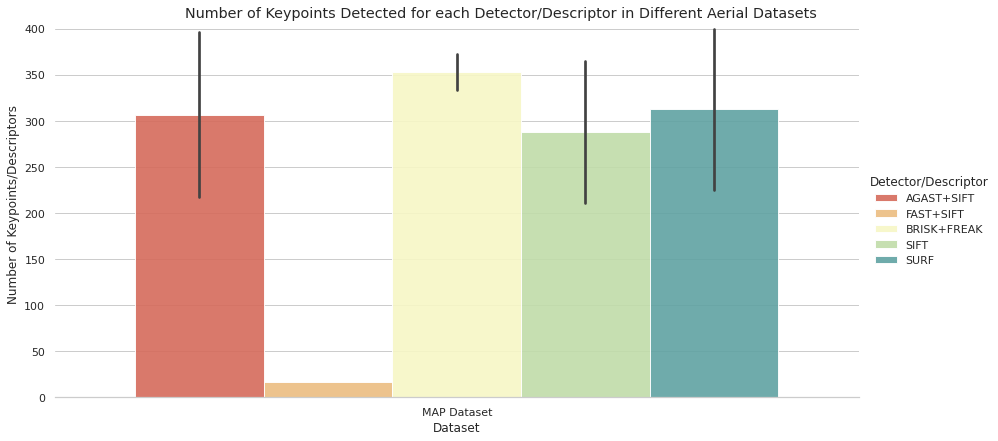

In [69]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_numkey_5, kind="bar",
    x="Dataset", y="Number of Keypoints", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=6, aspect=2
)
g.despine(left=True)
g.set_axis_labels("Dataset", "Number of Keypoints/Descriptors")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Number of Keypoints Detected for each Detector/Descriptor in Different Aerial Datasets")

In [ ]:
g.savefig(f'drive/MyDrive/Num_Kypoints_7_{Dataset}.png')

In [70]:
df_numkey_5.to_csv(f'drive/MyDrive/Num_Kypoints_5_{Dataset}.csv')

In [ ]:
#print(len(num_matches_agast))

Total Number of Matches Detected for each Detector+Descriptor

In [71]:
#df_match_15['Number of Total Matches'] =  num_matches_agast + num_matches_akaze + num_matches_brisk + num_matches_daisy + num_matches_fast + num_matches_freak + num_matches_gftt + num_matches_kaze + num_matches_mser + num_matches_orb + num_matches_rootsift + num_matches_sift + num_matches_briefstar + num_matches_superpoint+ num_matches_surf+ num_matches_surfsift
d = {'Dataset': [f'{Dataset}']*(num_detectors*(len_files-1)), 'Number of Total Matches': num_matches_sift + num_matches_surf + num_matches_freak + num_matches_agast + num_matches_fast, 'Detector/Descriptor': ['AGAST+SIFT']*(len_files-1) + ['SIFT']*(len_files-1) + ['BRISK+FREAK']*(len_files-1) + ['FAST+SIFT']*(len_files-1) + ['SURF']*(len_files-1)}
df_match_5 = pd.DataFrame(data=d)
df_match_5['Number of Total Matches'] = df_match_5['Number of Total Matches']/(len_files-1)

Text(0.5, 0.98, 'Total Number of Matches Detected for each Detector/Descriptor in Different Aerial Datasets')

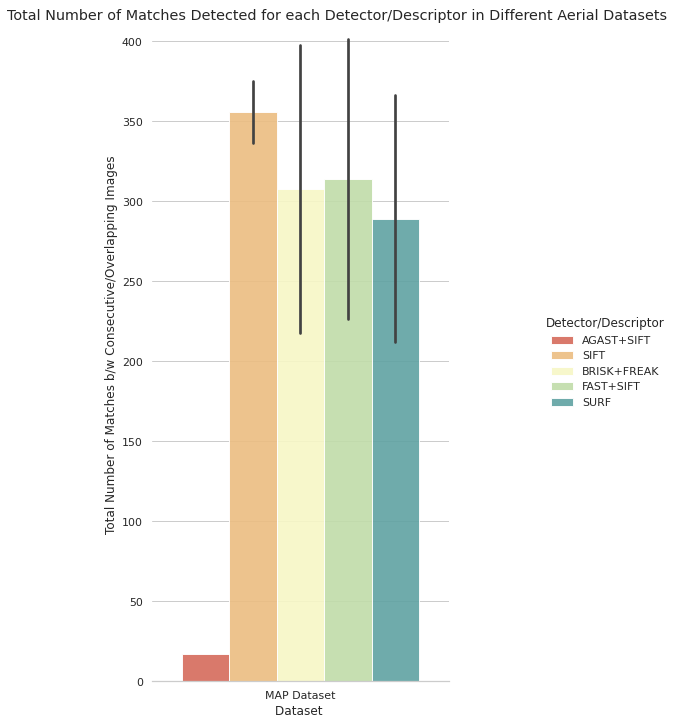

In [72]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_match_5, kind="bar",
    x="Dataset", y="Number of Total Matches", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset ", "Total Number of Matches b/w Consecutive/Overlapping Images")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Total Number of Matches Detected for each Detector/Descriptor in Different Aerial Datasets")

In [ ]:
g.savefig(f'drive/MyDrive/Num_Matches_7_{Dataset}.png')

In [ ]:
#df_match_16.to_csv('drive/MyDrive/Num_Matches_16.csv')

Total Number of Good/Robust Matches (NN+Lowe+RANSAC) Detected for each Detector+Descriptor

In [73]:
df_match_5['Number of Good Matches'] =  num_good_matches_sift + num_good_matches_surf + num_good_matches_freak + num_good_matches_agast + num_good_matches_fast
df_match_5['Number of Good Matches'] = df_match_5['Number of Good Matches']/(len_files-1)

Text(0.5, 0.98, 'Number of Good Matches (Lowe + RANSAC) Detected for each Detector/Descriptor in Different Aerial Datasets')

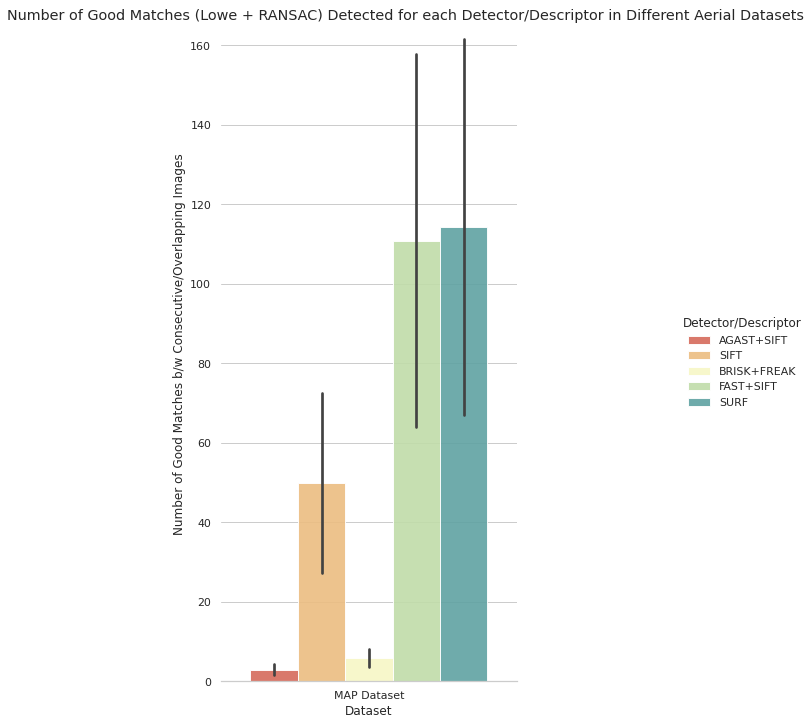

In [74]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_match_5, kind="bar",
    x="Dataset", y="Number of Good Matches", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset", "Number of Good Matches b/w Consecutive/Overlapping Images")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Number of Good Matches (Lowe + RANSAC) Detected for each Detector/Descriptor in Different Aerial Datasets")

In [ ]:
g.savefig('drive/MyDrive/Num_Good_Matches_7.png')

In [ ]:
#df_match_16.to_csv('drive/MyDrive/Num_Good_Matches_16.csv')

Recall Rate for each Detector+Descriptor

In [75]:
df_match_5['Recall Rate of Matches'] = df_match_5['Number of Good Matches']/df_match_5['Number of Total Matches']

Text(0.5, 0.98, 'Recall Rate of Matches Detected (Good/Total) for each Detector/Descriptor in Different Aerial Datasets (Higher the Better)')

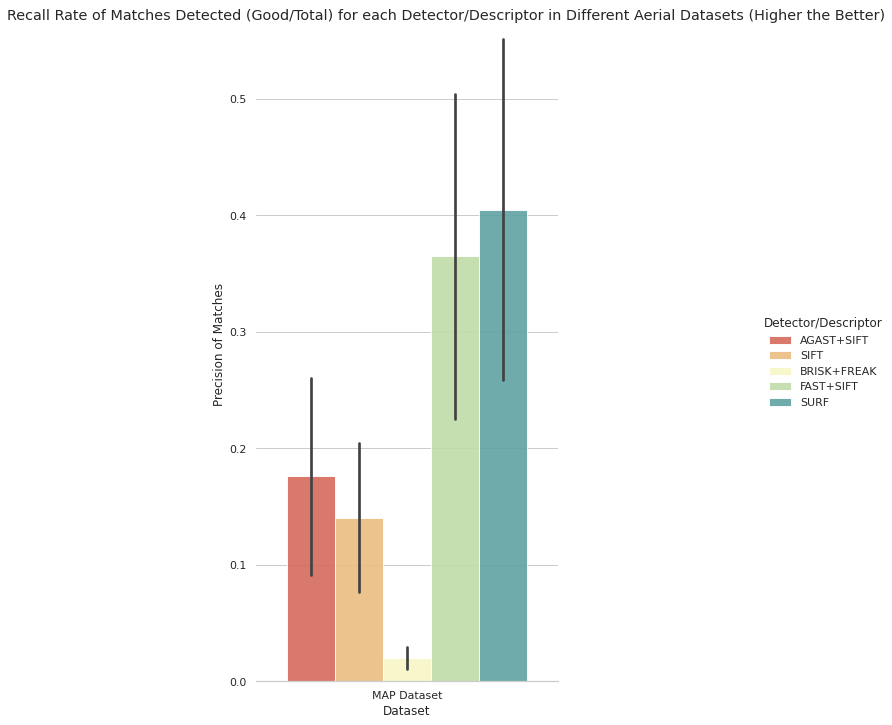

In [76]:
import seaborn as sns
sns.set_theme(style='whitegrid')


g = sns.catplot(
    data=df_match_5, kind="bar",
    x="Dataset", y="Recall Rate of Matches", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset", "Precision of Matches")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Recall Rate of Matches Detected (Good/Total) for each Detector/Descriptor in Different Aerial Datasets (Higher the Better)")

In [ ]:
g.savefig('drive/MyDrive/Recall_Rate_Matches_7.png')

1-Precision Rate for each Detector+Descriptor

In [77]:
df_match_5['1 - Precision Rate of Matches'] = (df_match_5['Number of Total Matches'] - df_match_5['Number of Good Matches'])/df_match_5['Number of Total Matches']

Text(0.5, 0.98, '1 - Precision rate of Matches Detected (False/Total Matches) for each Detector/Descriptor in Different Aerial Datasets (Lower the Better)')

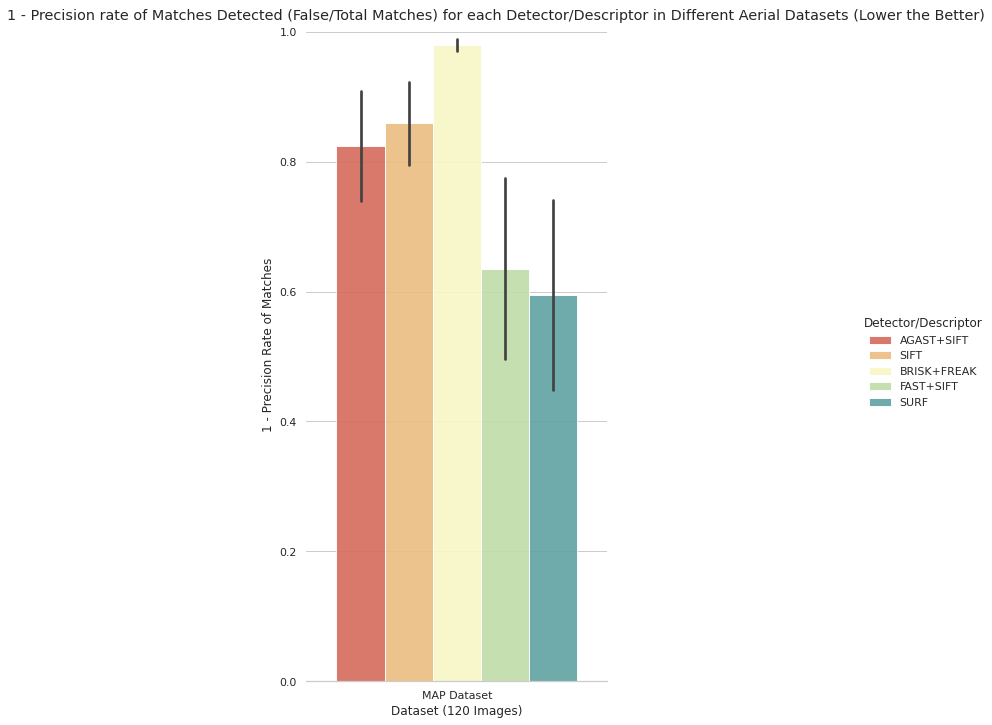

In [78]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_match_5, kind="bar",
    x="Dataset", y="1 - Precision Rate of Matches", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset (120 Images)", "1 - Precision Rate of Matches")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("1 - Precision rate of Matches Detected (False/Total Matches) for each Detector/Descriptor in Different Aerial Datasets (Lower the Better)")

In [ ]:
g.savefig('drive/MyDrive/One_minus_Precision_Rate_Matches_7.png')

F-Score for each Detector+Descriptor

In [79]:
df_match_5['F-Score'] = (2* (1 - df_match_5['1 - Precision Rate of Matches']) * df_match_5['Recall Rate of Matches'])/((1 - df_match_5['1 - Precision Rate of Matches']) + df_match_5['Recall Rate of Matches'])

Text(0.5, 0.98, 'F-Score of Matches Detected (2*P*R/P+R) for each Detector/Descriptor in Different Aerial Datasets (Higher the Better)')

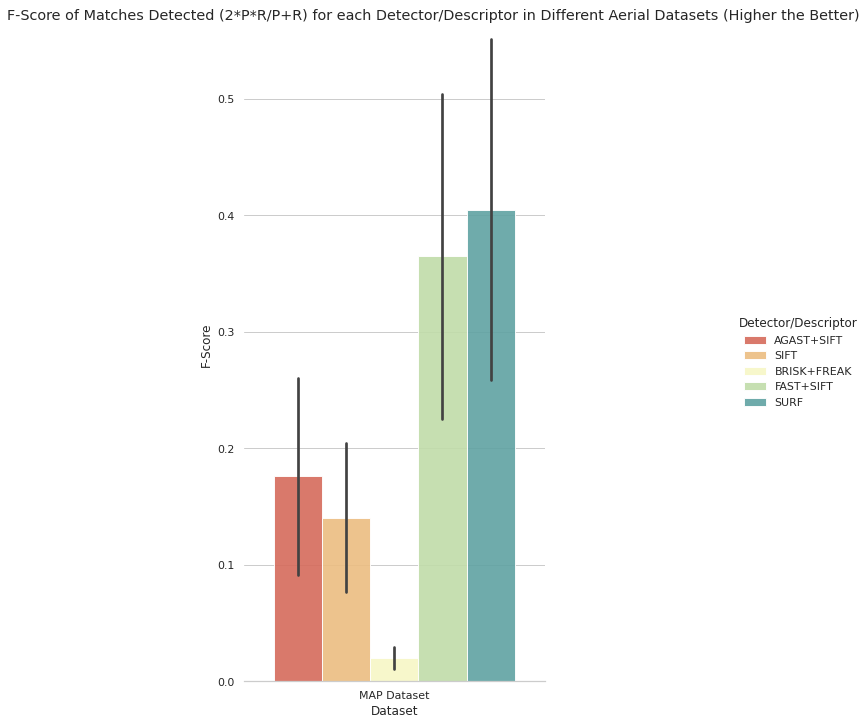

In [80]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_match_5, kind="bar",
    x="Dataset", y="F-Score", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset", "F-Score")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("F-Score of Matches Detected (2*P*R/P+R) for each Detector/Descriptor in Different Aerial Datasets (Higher the Better)")

In [ ]:
g.savefig('drive/MyDrive/F_Score_Rate_Matches_7.png')

In [81]:
df_match_5.to_csv('drive/MyDrive/All_metrics_5.csv')

Time for each Detector+Descriptor

In [82]:
d = {'Dataset': [f'{Dataset}']*(num_detectors), 'Time': [time_all[3]] + [time_all[0]] + [time_all[2]] + [time_all[1]] + [time_all[4]], 'Detector/Descriptor': ['AGAST+SIFT'] + ['FAST+SIFT']*(1) + ['BRISK+FREAK']*(1) + ['SURF']*(1) +  ['SIFT']*(1) }
df_time_5 = pd.DataFrame(data=d)

In [83]:
print(df_time_5)

       Dataset        Time Detector/Descriptor
0  MAP Dataset  163.213114          AGAST+SIFT
1  MAP Dataset  161.088703           FAST+SIFT
2  MAP Dataset  310.925907         BRISK+FREAK
3  MAP Dataset  341.525368                SURF
4  MAP Dataset  161.731876                SIFT


Text(0.5, 0.98, 'Time taken during Feature Extraction by each Detector/Descriptor in Different Aerial Datasets (Lower the Better)')

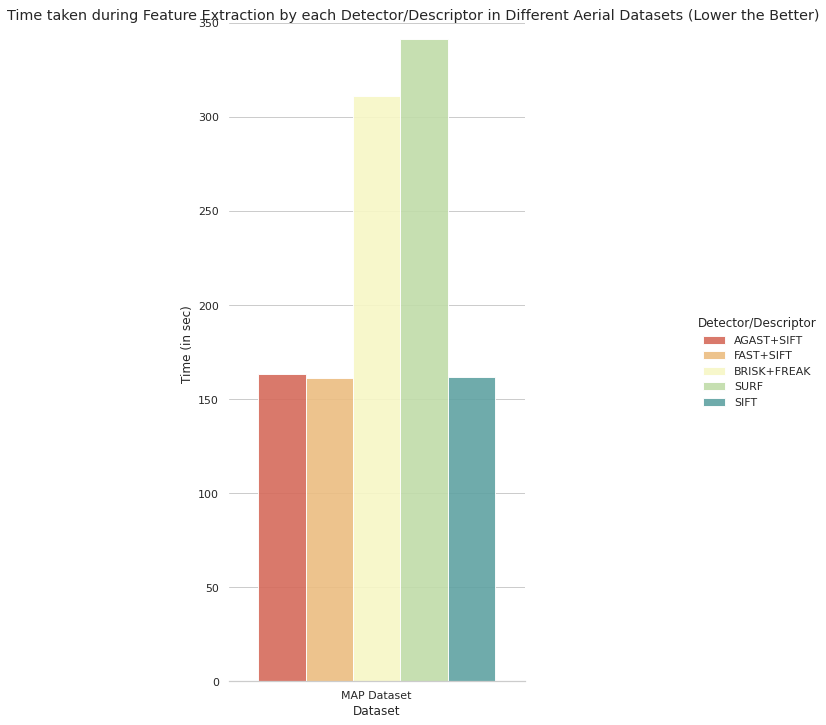

In [84]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_time_5, kind="bar",
    x="Dataset", y="Time", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset", "Time (in sec)")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Time taken during Feature Extraction by each Detector/Descriptor in Different Aerial Datasets (Lower the Better)")

In [ ]:
g.savefig('drive/MyDrive/Time_7.png')

In [85]:
df_time_5.to_csv('drive/MyDrive/Time_5.csv')

Stitching with CPU